## Self Driving Car
Problem Definition
We are here building a minimal version of self driving car. Here, we have a front camera view. This will transfer input to the computer. Then Deep Learning algorithm in computer predicts the steering angle to avoid all sorts of collisions. Predicting steering angle can be thought of as a regression problem. We will feed images to Convolutional Neural Network and the label will be the steering angle in that image. Model will learn the steering angle from the as per the turns in the image and will finally predicts steering angle for unknown images.

In [ ]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import scipy.misc

import cv2
import warnings
from tensorflow.core.protobuf import saver_pb2
from tensorflow.python.client import device_lib
from scipy import pi

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [4]:
from __future__ import division

import os
import numpy as np
import random

from scipy import pi
from itertools import islice

In [5]:

DATA_FOLDER = r"C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\driving_dataset"
DATA_FILE = os.path.join(DATA_FOLDER, r"C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\data.txt")

x = []
y = []

train_batch_pointer = 0
test_batch_pointer = 0

In [9]:
with open(os.path.join(DATA_FOLDER, r"C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\driving_dataset\data.txt")) as f:
    for line in f:
        image_name, angle = line.split()
        
        image_path = os.path.join(DATA_FOLDER, image_name)
        x.append(image_path)
        
        angle_radians = float(angle) * (pi / 180)  #converting angle into radians
        y.append(angle_radians)
y = np.array(y)
print(str(len(x))+" "+str(len(y)))

45406 45406


### Train_Test split(80-20)

In [10]:
split_ratio = int(len(x) * 0.8)

train_x = x[:split_ratio]
train_y = y[:split_ratio]

test_x = x[split_ratio:]
test_y = y[split_ratio:]

len(train_x), len(train_y), len(test_x), len(test_y)

(36324, 36324, 9082, 9082)

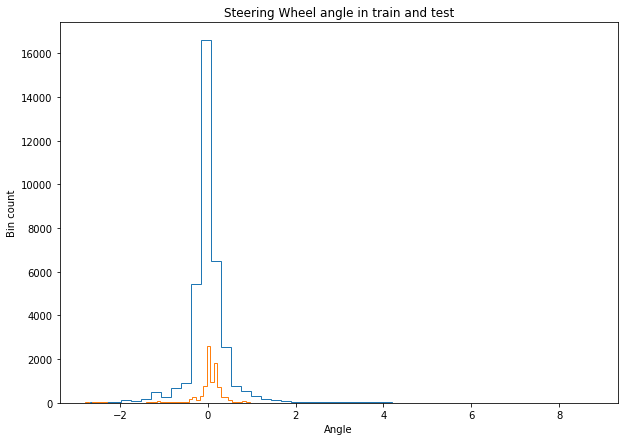

In [11]:

fig = plt.figure(figsize = (10, 7))
plt.hist(train_y, bins = 50, histtype = "step")
plt.hist(test_y, bins = 50, histtype = "step")
plt.title("Steering Wheel angle in train and test")
plt.xlabel("Angle")
plt.ylabel("Bin count")
plt.show()

In [12]:
def loadTrainBatch(batch_size):
    global train_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(train_x[(train_batch_pointer + i) % len(train_x)]) #here % len(train_x) is used to make sure that
        #"train_batch_pointer + i" should not cross the number of train images. As soon as the value of "train_batch_pointer" is
        #equal to number of train images then it will again start reading the train images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(train_y[(train_batch_pointer + i) % len(train_y)]) #appending corresponding labels
        
    train_batch_pointer += batch_size
        
    return x_result, y_result

In [13]:
def loadTestBatch(batch_size):
    global test_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(test_x[(test_batch_pointer + i) % len(test_x)]) #here % len(test_x) is used to make sure that
        #"test_batch_pointer + i" should not cross the number of test images. As soon as the value of "test_batch_pointer" is
        #equal to number of test images then it will again start reading the test images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(test_y[(test_batch_pointer + i) % len(test_y)]) #appending corresponding labels
        
    test_batch_pointer += batch_size
        
    return x_result, y_result

In [14]:
def weightVariable(shape):
    initial = tf.truncated_normal(shape = shape, stddev = 0.1)
    return tf.Variable(initial) 

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def convolution(previous_input, filter_input, strides):
    return tf.nn.conv2d(previous_input, filter_input, strides = [1, strides, strides, 1], padding = "VALID")

In [15]:

import tensorflow as tf
x_input = tf.placeholder(tf.float32, shape = [None, 66, 200, 3], name = "Plc_1")
y_true = tf.placeholder(tf.float32, name = "Plc_2")

input_image = x_input

In [16]:

#Convolution Layers
#First convolution layer
W_Conv1 = weightVariable([5,5,3,24])
B_Conv1 = bias_variable([24])
Conv1 = tf.nn.relu(convolution(input_image, W_Conv1, 2) + B_Conv1)
#strides = 2
#Output size: 31*98*24

#Second convolution layer
W_Conv2 = weightVariable([5,5,24,36])
B_Conv2 = bias_variable([36])
Conv2 = tf.nn.relu(convolution(Conv1, W_Conv2, 2) + B_Conv2)
#strides = 2
#Output size: 14*47*36

#Third convolution layer
W_Conv3 = weightVariable([5,5,36,48])
B_Conv3 = bias_variable([48])
Conv3 = tf.nn.relu(convolution(Conv2, W_Conv3, 2) + B_Conv3)
#strides = 2
#Output size: 5*22*48

#Fourth convolution layer
W_Conv4 = weightVariable([3,3,48,64])
B_Conv4 = bias_variable([64])
Conv4 = tf.nn.relu(convolution(Conv3, W_Conv4, 1) + B_Conv4)
#strides = 1
#Output size: 3*20*64


#Fifth convolution layer
W_Conv5 = weightVariable([3,3,64,64])
B_Conv5 = bias_variable([64])
Conv5 = tf.nn.relu(convolution(Conv4, W_Conv5, 1) + B_Conv5)
#strides = 1
#Output size: 1*18*64

#Fully-Connected Dense Layers
keep_prob = tf.placeholder(tf.float32)
#First FC-Dense
#Input = 1*18*64 = 1152
W_FC1 = weightVariable([1152, 1164])
B_FC1 = bias_variable([1164])
FC1_Flatten = tf.reshape(Conv5, [-1, 1152]) #here, -1 indicates 1. It means that the shape of FC1_Flatten will be 1*1152
Output_FC1 = tf.nn.relu(tf.matmul(FC1_Flatten, W_FC1) + B_FC1) #so, here shape of FC1_Flatten is 1*1152 and shape of W_FC1 will
#be 1152*1164. Therefore, there will be a matrix multiplication of matrices: (1*1152) * (1152*1164) = (1*1164).
Output_FC1_drop = tf.nn.dropout(Output_FC1, keep_prob)

#Second FC-Dense
#Input = 1*1164 = 1164
W_FC2 = weightVariable([1164, 100])
B_FC2 = bias_variable([100])
Output_FC2 = tf.nn.relu(tf.matmul(Output_FC1_drop, W_FC2) + B_FC2) #so, here shape of Output_FC1_drop is 1*1164 and shape of 
#W_FC2 will be 1164*100. Therefore, there will be a matrix multiplication of matrices: (1*1164) * (1164*100) = (1*100).
Output_FC2_drop = tf.nn.dropout(Output_FC2, keep_prob)

#Third FC-Dense
#Input = 1*100 = 100
W_FC3 = weightVariable([100, 50])
B_FC3 = bias_variable([50])
Output_FC3 = tf.nn.relu(tf.matmul(Output_FC2_drop, W_FC3) + B_FC3) #so, here shape of Output_FC2_drop is 1*100 and shape of 
#W_FC3 will be 100*50. Therefore, there will be a matrix multiplication of matrices: (1*100) * (100*50) = (1*50).
Output_FC3_drop = tf.nn.dropout(Output_FC3, keep_prob)

#Fourth FC-Dense
#Input = 1*50 = 50
W_FC4 = weightVariable([50, 10])
B_FC4 = bias_variable([10])
Output_FC4 = tf.nn.relu(tf.matmul(Output_FC3_drop, W_FC4) + B_FC4) #so, here shape of Output_FC3_drop is 1*50 and shape of 
#W_FC4 will be 50*10. Therefore, there will be a matrix multiplication of matrices: (1*50) * (50*10) = (1*10).
Output_FC4_drop = tf.nn.dropout(Output_FC4, keep_prob)

#Final Output to one neuron with linear/identity function
#Input = 1*10 = 10
W_FC5 = weightVariable([10, 1])
B_FC5 = bias_variable([1])
y_predicted = tf.identity(tf.matmul(Output_FC4_drop, W_FC5) + B_FC5) #so, here shape of Output_FC4_drop is 1*10 and shape of 
#W_FC5 will be 10*1. Therefore, there will be a matrix multiplication of matrices: (1*10) * (10*1) = (1*1). Since, this is a 
#regression problem so we have applied identity fuction in the end. We can also apply "atan" function here. If computational
#power is available then the model should be tested with both identity and atan functions. In the end, that function should be
#considered which gives better result.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:

%%time
SAVEDIR = "../Saver/"
sess = tf.InteractiveSession()

L2NormConst = 0.001
train_vars = tf.trainable_variables() #it will return all the variables. Here, all the weights and biases are variables which
#are trainable.

loss = tf.reduce_mean(tf.square(tf.subtract(y_true, y_predicted))) + tf.add_n([tf.nn.l2_loss(w) for w in train_vars]) * L2NormConst
#since this is a regression problem so above loss is mean-squared-error loss
train_step = tf.train.AdamOptimizer(learning_rate = 10**-4).minimize(loss)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

epochs = 30
batch_size = 100
epoch_number, train_loss, test_loss,  = [], [], []

for epoch in range(epochs):
    train_avg_loss = 0
    test_avg_loss = 0
    te_loss_old = 10000  #any big number can be given
    
    for i in range(int(len(x)/batch_size)):
        train_batch_x, train_batch_y = loadTrainBatch(batch_size)
        train_step.run(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 0.8})
        tr_loss = loss.eval(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 1.0})
        train_avg_loss += tr_loss / batch_size
    
        test_batch_x, test_batch_y = loadTestBatch(batch_size)
        te_loss_new = loss.eval(feed_dict = {x_input: test_batch_x, y_true: test_batch_y, keep_prob: 1.0})
        test_avg_loss += te_loss_new / batch_size
        
        if te_loss_new < te_loss_old:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {} *".format(epoch+1, tr_loss, te_loss_new))
        else:
            print("Epoch: {}, Train_Loss: {}, Test_Loss: {}".format(epoch+1, tr_loss, te_loss_new))
        te_loss_old = te_loss_new
        
        if (i+1) % batch_size == 0:
            if not os.path.exists(SAVEDIR):
                os.makedirs(SAVEDIR)
            save_path = os.path.join(SAVEDIR,r"C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt")
            saver.save(sess = sess, save_path = save_path)
            print("Model saved at location {} at epoch {}".format(save_path, epoch + 1))
        
    epoch_number.append(epoch)
    train_loss.append(train_avg_loss)
    test_loss.append(test_avg_loss)
    
#creating dataframe and record all the losses and accuracies at each epoch
log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
log_frame["Epoch"] = epoch_number
log_frame["Train Loss"] = train_loss
log_frame["Test Loss"] = test_loss
log_frame.to_csv(os.path.join(SAVEDIR, "log.csv"), index = False)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 1, Train_Loss: 6.174876689910889, Test_Loss: 6.241774082183838 *
Epoch: 1, Train_Loss: 6.157304763793945, Test_Loss: 6.304219722747803
Epoch: 1, Train_Loss: 6.1491570472717285, Test_Loss: 6.162303447723389 *
Epoch: 1, Train_Loss: 6.142899990081787, Test_Loss: 6.161448955535889 *
Epoch: 1, Train_Loss: 6.137180805206299, Test_Loss: 6.1463704109191895 *
Epoch: 1, Train_Loss: 6.294179439544678, Test_Loss: 6.163755416870117
Epoch: 1, Train_Loss: 10.779863357543945, Test_Loss: 6.185640811920166
Epoch: 1, Train_Loss: 6.162837982177734, Test_Loss: 6.146432399749756 *
Epoch: 1, Train_Loss: 6.111608505249023, Test_Loss: 6.10966157913208 *
Epoch: 1, Train_Loss: 6.105567455291748, Test_Loss: 6.224362850189209
Epoch: 1, Train_Loss: 6.089389324188232, Test_Loss: 6.52421760559082
Epoch: 1, Train_Loss: 6.081638336181641, Test_Loss: 6.212978839874268 *
Epoch: 1, Train_Loss: 6.075056076049805, Test_Loss: 6.225851535797119
Epoch: 1, Train_Loss: 6.066782474517822, Test_Loss: 6.079155921936035 *
Epo

Epoch: 1, Train_Loss: 5.379415035247803, Test_Loss: 5.368374347686768 *
Epoch: 1, Train_Loss: 5.479959487915039, Test_Loss: 5.359352111816406 *
Epoch: 1, Train_Loss: 5.537711143493652, Test_Loss: 5.3594441413879395
Epoch: 1, Train_Loss: 5.348519802093506, Test_Loss: 5.350827693939209 *
Epoch: 1, Train_Loss: 5.361721992492676, Test_Loss: 5.344637393951416 *
Epoch: 1, Train_Loss: 5.33598518371582, Test_Loss: 5.3378400802612305 *
Epoch: 1, Train_Loss: 5.330655097961426, Test_Loss: 5.333582878112793 *
Epoch: 1, Train_Loss: 5.323042869567871, Test_Loss: 5.332274913787842 *
Epoch: 1, Train_Loss: 5.314636707305908, Test_Loss: 5.331053256988525 *
Epoch: 1, Train_Loss: 5.335860729217529, Test_Loss: 5.316256523132324 *
Epoch: 1, Train_Loss: 5.334444522857666, Test_Loss: 5.303079605102539 *
Epoch: 1, Train_Loss: 5.3284173011779785, Test_Loss: 5.294083595275879 *
Epoch: 1, Train_Loss: 5.322332382202148, Test_Loss: 5.289494037628174 *
Epoch: 1, Train_Loss: 5.316775321960449, Test_Loss: 5.2819519042

Epoch: 1, Train_Loss: 4.673588275909424, Test_Loss: 4.666406154632568 *
Epoch: 1, Train_Loss: 4.672527313232422, Test_Loss: 4.691978454589844
Epoch: 1, Train_Loss: 4.682843208312988, Test_Loss: 4.692328929901123
Epoch: 1, Train_Loss: 5.1773576736450195, Test_Loss: 8.213348388671875
Epoch: 1, Train_Loss: 5.136793613433838, Test_Loss: 6.690032958984375 *
Epoch: 1, Train_Loss: 5.13552188873291, Test_Loss: 4.640528678894043 *
Epoch: 1, Train_Loss: 5.518103122711182, Test_Loss: 4.636523246765137 *
Epoch: 1, Train_Loss: 4.7916178703308105, Test_Loss: 4.67399263381958
Epoch: 1, Train_Loss: 5.278739929199219, Test_Loss: 4.678576946258545
Epoch: 1, Train_Loss: 4.852049827575684, Test_Loss: 4.637874603271484 *
Epoch: 1, Train_Loss: 4.616918087005615, Test_Loss: 4.687594890594482
Epoch: 1, Train_Loss: 4.619369983673096, Test_Loss: 4.7138590812683105
Epoch: 1, Train_Loss: 4.67611837387085, Test_Loss: 4.599643230438232 *
Epoch: 1, Train_Loss: 4.754197120666504, Test_Loss: 4.635135650634766
Epoch: 1

Epoch: 1, Train_Loss: 4.094793319702148, Test_Loss: 4.091252326965332 *
Epoch: 1, Train_Loss: 4.0908403396606445, Test_Loss: 4.085369110107422 *
Epoch: 1, Train_Loss: 4.086386680603027, Test_Loss: 4.080645561218262 *
Epoch: 1, Train_Loss: 4.101454257965088, Test_Loss: 4.07609224319458 *
Epoch: 1, Train_Loss: 4.070986270904541, Test_Loss: 4.07143497467041 *
Epoch: 1, Train_Loss: 4.068503379821777, Test_Loss: 4.065938472747803 *
Epoch: 1, Train_Loss: 4.086204528808594, Test_Loss: 4.071558475494385
Epoch: 1, Train_Loss: 4.125800132751465, Test_Loss: 4.064357757568359 *
Epoch: 1, Train_Loss: 4.097689628601074, Test_Loss: 4.055026531219482 *
Epoch: 1, Train_Loss: 4.0482635498046875, Test_Loss: 4.053590297698975 *
Epoch: 1, Train_Loss: 4.04626989364624, Test_Loss: 4.081964492797852
Epoch: 1, Train_Loss: 4.089653015136719, Test_Loss: 4.059822082519531 *
Epoch: 1, Train_Loss: 4.135678768157959, Test_Loss: 4.235864639282227
Epoch: 1, Train_Loss: 4.112123012542725, Test_Loss: 4.537012100219727
E

Epoch: 2, Train_Loss: 3.611839532852173, Test_Loss: 3.689706802368164 *
Epoch: 2, Train_Loss: 3.6093521118164062, Test_Loss: 3.580679416656494 *
Epoch: 2, Train_Loss: 3.5762808322906494, Test_Loss: 3.5839428901672363
Epoch: 2, Train_Loss: 3.607759952545166, Test_Loss: 3.5783016681671143 *
Epoch: 2, Train_Loss: 3.5863401889801025, Test_Loss: 3.5856075286865234
Epoch: 2, Train_Loss: 3.5670723915100098, Test_Loss: 3.612398862838745
Epoch: 2, Train_Loss: 3.5932834148406982, Test_Loss: 3.6061465740203857 *
Epoch: 2, Train_Loss: 3.5898873805999756, Test_Loss: 3.5639007091522217 *
Epoch: 2, Train_Loss: 3.672260284423828, Test_Loss: 3.654019594192505
Epoch: 2, Train_Loss: 3.661773204803467, Test_Loss: 3.942138195037842
Epoch: 2, Train_Loss: 3.625065326690674, Test_Loss: 3.6198129653930664 *
Epoch: 2, Train_Loss: 3.5721681118011475, Test_Loss: 3.6798274517059326
Epoch: 2, Train_Loss: 3.5374059677124023, Test_Loss: 3.5416438579559326 *
Epoch: 2, Train_Loss: 3.56101393699646, Test_Loss: 3.5377857

Epoch: 2, Train_Loss: 3.6168148517608643, Test_Loss: 3.1542794704437256
Epoch: 2, Train_Loss: 3.876542568206787, Test_Loss: 3.1506612300872803 *
Epoch: 2, Train_Loss: 3.4560658931732178, Test_Loss: 3.142327070236206 *
Epoch: 2, Train_Loss: 3.1654489040374756, Test_Loss: 3.1433780193328857
Epoch: 2, Train_Loss: 3.1481895446777344, Test_Loss: 3.1378836631774902 *
Epoch: 2, Train_Loss: 3.4070498943328857, Test_Loss: 3.134681224822998 *
Epoch: 2, Train_Loss: 4.850989818572998, Test_Loss: 3.132046937942505 *
Epoch: 2, Train_Loss: 3.585484027862549, Test_Loss: 3.131030559539795 *
Epoch: 2, Train_Loss: 3.137394905090332, Test_Loss: 3.1332602500915527
Epoch: 2, Train_Loss: 3.129789113998413, Test_Loss: 3.141328811645508
Epoch: 2, Train_Loss: 3.114821672439575, Test_Loss: 3.126523733139038 *
Epoch: 2, Train_Loss: 3.4577889442443848, Test_Loss: 3.1106626987457275 *
Epoch: 2, Train_Loss: 3.2377607822418213, Test_Loss: 3.1057257652282715 *
Epoch: 2, Train_Loss: 3.162233352661133, Test_Loss: 3.1026

Epoch: 2, Train_Loss: 3.003072738647461, Test_Loss: 2.785813808441162 *
Epoch: 2, Train_Loss: 2.9660255908966064, Test_Loss: 2.783277750015259 *
Epoch: 2, Train_Loss: 2.8524768352508545, Test_Loss: 2.7783639430999756 *
Epoch: 2, Train_Loss: 2.82161545753479, Test_Loss: 2.7775719165802 *
Epoch: 2, Train_Loss: 2.8876559734344482, Test_Loss: 2.794259786605835
Epoch: 2, Train_Loss: 2.874924898147583, Test_Loss: 2.8186824321746826
Epoch: 2, Train_Loss: 2.9139509201049805, Test_Loss: 5.882138252258301
Epoch: 2, Train_Loss: 2.890718936920166, Test_Loss: 5.407672882080078 *
Epoch: 2, Train_Loss: 2.8557348251342773, Test_Loss: 2.764086961746216 *
Epoch: 2, Train_Loss: 2.7538437843322754, Test_Loss: 2.7586777210235596 *
Epoch: 2, Train_Loss: 2.8153574466705322, Test_Loss: 2.7830772399902344
Epoch: 2, Train_Loss: 2.788264274597168, Test_Loss: 2.7868919372558594
Epoch: 2, Train_Loss: 2.7564070224761963, Test_Loss: 2.7710976600646973 *
Epoch: 2, Train_Loss: 2.7438864707946777, Test_Loss: 2.82062816

Epoch: 2, Train_Loss: 2.5141165256500244, Test_Loss: 2.50290846824646 *
Epoch: 2, Train_Loss: 2.529386281967163, Test_Loss: 2.606602907180786
Epoch: 2, Train_Loss: 2.5014808177948, Test_Loss: 2.5655391216278076 *
Epoch: 2, Train_Loss: 2.4521825313568115, Test_Loss: 2.4713027477264404 *
Epoch: 2, Train_Loss: 2.4502477645874023, Test_Loss: 2.45811128616333 *
Epoch: 2, Train_Loss: 2.4471497535705566, Test_Loss: 2.4566502571105957 *
Epoch: 2, Train_Loss: 2.444173574447632, Test_Loss: 2.453275442123413 *
Epoch: 2, Train_Loss: 2.4428162574768066, Test_Loss: 2.4512617588043213 *
Epoch: 2, Train_Loss: 2.4380223751068115, Test_Loss: 2.4494943618774414 *
Epoch: 2, Train_Loss: 2.435499668121338, Test_Loss: 2.4465808868408203 *
Epoch: 2, Train_Loss: 2.4335639476776123, Test_Loss: 2.4411401748657227 *
Epoch: 2, Train_Loss: 2.430101156234741, Test_Loss: 2.4511749744415283
Epoch: 2, Train_Loss: 2.4274919033050537, Test_Loss: 2.4476401805877686 *
Epoch: 2, Train_Loss: 2.428826332092285, Test_Loss: 2.4

Epoch: 2, Train_Loss: 2.459071159362793, Test_Loss: 2.2120261192321777 *
Epoch: 2, Train_Loss: 2.483790397644043, Test_Loss: 2.1872060298919678 *
Epoch: 2, Train_Loss: 2.2597625255584717, Test_Loss: 2.271826982498169
Epoch: 2, Train_Loss: 2.3101212978363037, Test_Loss: 2.9193005561828613
Epoch: 2, Train_Loss: 2.389533758163452, Test_Loss: 3.5502007007598877
Epoch: 3, Train_Loss: 2.634864091873169, Test_Loss: 2.401892900466919 *
Epoch: 3, Train_Loss: 2.519993305206299, Test_Loss: 2.2658767700195312 *
Epoch: 3, Train_Loss: 2.190070867538452, Test_Loss: 2.163952589035034 *
Epoch: 3, Train_Loss: 2.3025407791137695, Test_Loss: 2.1684083938598633
Epoch: 3, Train_Loss: 2.30753755569458, Test_Loss: 2.1622724533081055 *
Epoch: 3, Train_Loss: 2.166210651397705, Test_Loss: 2.172966718673706
Epoch: 3, Train_Loss: 2.168769121170044, Test_Loss: 2.1796841621398926
Epoch: 3, Train_Loss: 2.1517579555511475, Test_Loss: 2.1882400512695312
Epoch: 3, Train_Loss: 2.1517090797424316, Test_Loss: 2.15435242652

Epoch: 3, Train_Loss: 1.992725133895874, Test_Loss: 1.9435395002365112 *
Epoch: 3, Train_Loss: 2.0030081272125244, Test_Loss: 1.9782472848892212
Epoch: 3, Train_Loss: 1.9658690690994263, Test_Loss: 7.564077854156494
Epoch: 3, Train_Loss: 1.9472250938415527, Test_Loss: 2.2220687866210938 *
Epoch: 3, Train_Loss: 1.9426782131195068, Test_Loss: 1.9538978338241577 *
Epoch: 3, Train_Loss: 1.9347447156906128, Test_Loss: 1.946244239807129 *
Epoch: 3, Train_Loss: 1.9325840473175049, Test_Loss: 1.9359556436538696 *
Epoch: 3, Train_Loss: 1.9328727722167969, Test_Loss: 1.938597321510315
Epoch: 3, Train_Loss: 1.9309701919555664, Test_Loss: 1.9392368793487549
Epoch: 3, Train_Loss: 1.9319648742675781, Test_Loss: 1.960031509399414
Epoch: 3, Train_Loss: 1.9265937805175781, Test_Loss: 1.9438470602035522 *
Epoch: 3, Train_Loss: 1.924780249595642, Test_Loss: 1.945462703704834
Epoch: 3, Train_Loss: 1.9225785732269287, Test_Loss: 1.9464426040649414
Epoch: 3, Train_Loss: 1.9211194515228271, Test_Loss: 1.9482

Epoch: 3, Train_Loss: 1.876930832862854, Test_Loss: 1.7514249086380005 *
Epoch: 3, Train_Loss: 1.8573188781738281, Test_Loss: 1.7526055574417114
Epoch: 3, Train_Loss: 1.92425537109375, Test_Loss: 1.747813105583191 *
Epoch: 3, Train_Loss: 1.8172273635864258, Test_Loss: 1.7496341466903687
Epoch: 3, Train_Loss: 1.8964016437530518, Test_Loss: 1.7476767301559448 *
Epoch: 3, Train_Loss: 1.8812575340270996, Test_Loss: 1.745364785194397 *
Epoch: 3, Train_Loss: 2.066697120666504, Test_Loss: 1.7432602643966675 *
Epoch: 3, Train_Loss: 1.7465178966522217, Test_Loss: 1.7426079511642456 *
Epoch: 3, Train_Loss: 1.77618408203125, Test_Loss: 1.7386252880096436 *
Epoch: 3, Train_Loss: 4.834329605102539, Test_Loss: 1.7395962476730347
Epoch: 3, Train_Loss: 2.0042436122894287, Test_Loss: 1.7480664253234863
Epoch: 3, Train_Loss: 1.7591662406921387, Test_Loss: 1.790101408958435
Epoch: 3, Train_Loss: 1.7710621356964111, Test_Loss: 4.210219860076904
Epoch: 3, Train_Loss: 1.7684974670410156, Test_Loss: 4.849490

Epoch: 3, Train_Loss: 1.7556599378585815, Test_Loss: 1.572906732559204 *
Epoch: 3, Train_Loss: 1.5934829711914062, Test_Loss: 1.607405662536621
Epoch: 3, Train_Loss: 1.5729682445526123, Test_Loss: 1.5870269536972046 *
Epoch: 3, Train_Loss: 1.5728240013122559, Test_Loss: 1.581585168838501 *
Epoch: 3, Train_Loss: 1.636046051979065, Test_Loss: 1.5716571807861328 *
Epoch: 3, Train_Loss: 1.5729273557662964, Test_Loss: 1.6541093587875366
Epoch: 3, Train_Loss: 1.575879693031311, Test_Loss: 1.6150575876235962 *
Epoch: 3, Train_Loss: 2.4022908210754395, Test_Loss: 1.6687958240509033
Epoch: 3, Train_Loss: 2.9432358741760254, Test_Loss: 1.6364526748657227 *
Epoch: 3, Train_Loss: 2.156038761138916, Test_Loss: 1.600843906402588 *
Epoch: 3, Train_Loss: 1.6682026386260986, Test_Loss: 1.584222674369812 *
Epoch: 3, Train_Loss: 2.3546369075775146, Test_Loss: 1.574493169784546 *
Epoch: 3, Train_Loss: 3.8335890769958496, Test_Loss: 1.5731092691421509 *
Epoch: 3, Train_Loss: 1.9094858169555664, Test_Loss: 

Epoch: 3, Train_Loss: 1.4336353540420532, Test_Loss: 1.4263652563095093 *
Epoch: 3, Train_Loss: 1.4987295866012573, Test_Loss: 1.4446609020233154
Epoch: 3, Train_Loss: 1.4243254661560059, Test_Loss: 1.5519318580627441
Epoch: 3, Train_Loss: 1.4516360759735107, Test_Loss: 1.6893011331558228
Epoch: 3, Train_Loss: 17.050994873046875, Test_Loss: 1.5589594841003418 *
Epoch: 3, Train_Loss: 2.4027411937713623, Test_Loss: 1.4631905555725098 *
Epoch: 3, Train_Loss: 2.6220221519470215, Test_Loss: 1.4192289113998413 *
Epoch: 3, Train_Loss: 3.630192279815674, Test_Loss: 1.4419766664505005
Epoch: 3, Train_Loss: 1.4486033916473389, Test_Loss: 1.454993486404419
Epoch: 3, Train_Loss: 1.46339750289917, Test_Loss: 1.6258962154388428
Epoch: 3, Train_Loss: 2.8642945289611816, Test_Loss: 1.8918119668960571
Epoch: 4, Train_Loss: 10.806530952453613, Test_Loss: 1.854583740234375 *
Epoch: 4, Train_Loss: 1.842220664024353, Test_Loss: 1.4339104890823364 *
Epoch: 4, Train_Loss: 1.4328941106796265, Test_Loss: 1.455

Epoch: 4, Train_Loss: 1.3082295656204224, Test_Loss: 1.692135214805603
Epoch: 4, Train_Loss: 1.3064827919006348, Test_Loss: 1.3787155151367188 *
Epoch: 4, Train_Loss: 1.3076698780059814, Test_Loss: 1.4474925994873047
Epoch: 4, Train_Loss: 1.3070493936538696, Test_Loss: 1.307657241821289 *
Epoch: 4, Train_Loss: 1.3043855428695679, Test_Loss: 1.3068830966949463 *
Epoch: 4, Train_Loss: 1.3031120300292969, Test_Loss: 1.3060604333877563 *
Epoch: 4, Train_Loss: 1.4006747007369995, Test_Loss: 1.3050143718719482 *
Epoch: 4, Train_Loss: 1.4040303230285645, Test_Loss: 1.3143690824508667
Epoch: 4, Train_Loss: 1.4250675439834595, Test_Loss: 6.372708320617676
Epoch: 4, Train_Loss: 1.382394552230835, Test_Loss: 1.866121530532837 *
Epoch: 4, Train_Loss: 1.2975852489471436, Test_Loss: 1.304157018661499 *
Epoch: 4, Train_Loss: 1.4025425910949707, Test_Loss: 1.296688199043274 *
Epoch: 4, Train_Loss: 1.4746538400650024, Test_Loss: 1.2961167097091675 *
Epoch: 4, Train_Loss: 1.4730205535888672, Test_Loss: 

Epoch: 4, Train_Loss: 1.205315113067627, Test_Loss: 1.2257925271987915
Epoch: 4, Train_Loss: 1.227555751800537, Test_Loss: 1.2162485122680664 *
Epoch: 4, Train_Loss: 1.2289118766784668, Test_Loss: 1.2067267894744873 *
Epoch: 4, Train_Loss: 1.226006031036377, Test_Loss: 1.202484130859375 *
Epoch: 4, Train_Loss: 1.2215955257415771, Test_Loss: 1.204129934310913
Epoch: 4, Train_Loss: 1.2290199995040894, Test_Loss: 1.2020782232284546 *
Epoch: 4, Train_Loss: 1.2091550827026367, Test_Loss: 1.200218915939331 *
Epoch: 4, Train_Loss: 1.2020148038864136, Test_Loss: 1.202581524848938
Epoch: 4, Train_Loss: 1.197696328163147, Test_Loss: 1.1987730264663696 *
Epoch: 4, Train_Loss: 1.216488242149353, Test_Loss: 1.2004430294036865
Epoch: 4, Train_Loss: 1.2196779251098633, Test_Loss: 1.200524926185608
Epoch: 4, Train_Loss: 1.2151085138320923, Test_Loss: 1.1976357698440552 *
Epoch: 4, Train_Loss: 1.1983708143234253, Test_Loss: 1.1966018676757812 *
Epoch: 4, Train_Loss: 1.2678147554397583, Test_Loss: 1.196

Epoch: 4, Train_Loss: 1.8446288108825684, Test_Loss: 1.164015293121338
Epoch: 4, Train_Loss: 1.302607774734497, Test_Loss: 1.1886752843856812
Epoch: 4, Train_Loss: 1.3968966007232666, Test_Loss: 1.1283732652664185 *
Epoch: 4, Train_Loss: 1.205418348312378, Test_Loss: 1.1448676586151123
Epoch: 4, Train_Loss: 1.122864007949829, Test_Loss: 1.159613847732544
Epoch: 4, Train_Loss: 1.1159939765930176, Test_Loss: 1.1735702753067017
Epoch: 4, Train_Loss: 1.1453602313995361, Test_Loss: 1.1328779458999634 *
Epoch: 4, Train_Loss: 1.3371179103851318, Test_Loss: 1.1545544862747192
Epoch: 4, Train_Loss: 1.5983383655548096, Test_Loss: 1.2234761714935303
Epoch: 4, Train_Loss: 1.463581919670105, Test_Loss: 1.259028673171997
Epoch: 4, Train_Loss: 3.0446219444274902, Test_Loss: 1.199295163154602 *
Epoch: 4, Train_Loss: 1.547921895980835, Test_Loss: 1.1810784339904785 *
Epoch: 4, Train_Loss: 1.9897217750549316, Test_Loss: 1.1390339136123657 *
Epoch: 4, Train_Loss: 1.1758660078048706, Test_Loss: 1.15599489

Epoch: 4, Train_Loss: 1.0373528003692627, Test_Loss: 1.0345708131790161 *
Epoch: 4, Train_Loss: 1.0384012460708618, Test_Loss: 1.0310853719711304 *
Epoch: 4, Train_Loss: 1.0578923225402832, Test_Loss: 1.0339176654815674
Epoch: 4, Train_Loss: 1.0851603746414185, Test_Loss: 1.0296361446380615 *
Epoch: 4, Train_Loss: 1.0633488893508911, Test_Loss: 1.0336133241653442
Epoch: 4, Train_Loss: 1.0353832244873047, Test_Loss: 1.0455001592636108
Epoch: 4, Train_Loss: 1.0355136394500732, Test_Loss: 1.038604736328125 *
Epoch: 4, Train_Loss: 1.0774314403533936, Test_Loss: 1.0479122400283813
Epoch: 4, Train_Loss: 1.0972448587417603, Test_Loss: 1.140357494354248
Epoch: 4, Train_Loss: 1.0749632120132446, Test_Loss: 1.4397406578063965
Epoch: 4, Train_Loss: 1.0536775588989258, Test_Loss: 1.3101608753204346 *
Epoch: 4, Train_Loss: 1.0754942893981934, Test_Loss: 1.1063916683197021 *
Epoch: 4, Train_Loss: 1.109972596168518, Test_Loss: 1.0315611362457275 *
Epoch: 4, Train_Loss: 1.0978038311004639, Test_Loss: 

Epoch: 5, Train_Loss: 0.979209840297699, Test_Loss: 0.9729281067848206
Epoch: 5, Train_Loss: 0.9600542783737183, Test_Loss: 0.9922748804092407
Epoch: 5, Train_Loss: 0.9788265824317932, Test_Loss: 1.001932144165039
Epoch: 5, Train_Loss: 0.9858710169792175, Test_Loss: 0.963203489780426 *
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 5
Epoch: 5, Train_Loss: 1.0707497596740723, Test_Loss: 1.0652433633804321
Epoch: 5, Train_Loss: 1.0562894344329834, Test_Loss: 1.3339247703552246
Epoch: 5, Train_Loss: 1.0244148969650269, Test_Loss: 1.048904299736023 *
Epoch: 5, Train_Loss: 0.9809485673904419, Test_Loss: 1.1280250549316406
Epoch: 5, Train_Loss: 0.9566421508789062, Test_Loss: 0.9602880477905273 *
Epoch: 5, Train_Loss: 0.9800764918327332, Test_Loss: 0.9596743583679199 *
Epoch: 5, Train_Loss: 0.952814519405365, Test_Loss: 0.9590665102005005 *
Epoch: 5, Train_Loss: 0.9594809412956238, Test_Loss: 0.9584826231002808 *
Epoch: 5, Tr

Epoch: 5, Train_Loss: 1.0863112211227417, Test_Loss: 0.9072427153587341
Epoch: 5, Train_Loss: 0.9124305844306946, Test_Loss: 0.9325046539306641
Epoch: 5, Train_Loss: 0.9150851368904114, Test_Loss: 0.9063350558280945 *
Epoch: 5, Train_Loss: 1.1384351253509521, Test_Loss: 0.9084081649780273
Epoch: 5, Train_Loss: 2.105607748031616, Test_Loss: 0.9227797389030457
Epoch: 5, Train_Loss: 1.231830358505249, Test_Loss: 0.9498629570007324
Epoch: 5, Train_Loss: 0.9253501296043396, Test_Loss: 0.9002337455749512 *
Epoch: 5, Train_Loss: 0.9022744297981262, Test_Loss: 0.8918172121047974 *
Epoch: 5, Train_Loss: 0.8970263600349426, Test_Loss: 0.9051477313041687
Epoch: 5, Train_Loss: 1.283841609954834, Test_Loss: 0.9082046747207642
Epoch: 5, Train_Loss: 1.0290411710739136, Test_Loss: 0.8994919657707214 *
Epoch: 5, Train_Loss: 0.8991098999977112, Test_Loss: 0.915698766708374
Epoch: 5, Train_Loss: 1.2122961282730103, Test_Loss: 0.9187982678413391
Epoch: 5, Train_Loss: 0.907523512840271, Test_Loss: 0.902663

Epoch: 5, Train_Loss: 0.886085569858551, Test_Loss: 0.8727913498878479 *
Epoch: 5, Train_Loss: 0.889352560043335, Test_Loss: 0.8703376054763794 *
Epoch: 5, Train_Loss: 0.9560815095901489, Test_Loss: 0.8946738243103027
Epoch: 5, Train_Loss: 0.959111750125885, Test_Loss: 0.9201880097389221
Epoch: 5, Train_Loss: 0.9789755344390869, Test_Loss: 3.4076123237609863
Epoch: 5, Train_Loss: 0.9535163640975952, Test_Loss: 4.385313987731934
Epoch: 5, Train_Loss: 0.9371790885925293, Test_Loss: 0.8539432287216187 *
Epoch: 5, Train_Loss: 0.8372573852539062, Test_Loss: 0.8415240049362183 *
Epoch: 5, Train_Loss: 0.8838939070701599, Test_Loss: 0.8427243828773499
Epoch: 5, Train_Loss: 0.8738500475883484, Test_Loss: 0.8359030485153198 *
Epoch: 5, Train_Loss: 0.8493480682373047, Test_Loss: 0.8510249257087708
Epoch: 5, Train_Loss: 0.8376495242118835, Test_Loss: 0.9037185907363892
Epoch: 5, Train_Loss: 0.837859034538269, Test_Loss: 1.0064678192138672
Epoch: 5, Train_Loss: 0.8449974060058594, Test_Loss: 0.8387

Epoch: 5, Train_Loss: 0.835486650466919, Test_Loss: 0.8467857837677002 *
Epoch: 5, Train_Loss: 0.8131672739982605, Test_Loss: 0.8473978042602539
Epoch: 5, Train_Loss: 0.7905633449554443, Test_Loss: 0.8283769488334656 *
Epoch: 5, Train_Loss: 0.7884080410003662, Test_Loss: 0.8086348176002502 *
Epoch: 5, Train_Loss: 0.7866233587265015, Test_Loss: 0.7939760088920593 *
Epoch: 5, Train_Loss: 0.7869794368743896, Test_Loss: 0.8008852005004883
Epoch: 5, Train_Loss: 0.7912107706069946, Test_Loss: 0.8005385398864746 *
Epoch: 5, Train_Loss: 0.7925333380699158, Test_Loss: 0.80720055103302
Epoch: 5, Train_Loss: 0.7934053540229797, Test_Loss: 0.8032155632972717 *
Epoch: 5, Train_Loss: 0.785171627998352, Test_Loss: 0.7899588942527771 *
Epoch: 5, Train_Loss: 0.7837748527526855, Test_Loss: 0.7983427047729492
Epoch: 5, Train_Loss: 0.7927532196044922, Test_Loss: 0.7934912443161011 *
Epoch: 5, Train_Loss: 0.8056122660636902, Test_Loss: 0.7994948029518127
Epoch: 5, Train_Loss: 0.8125370144844055, Test_Loss:

Epoch: 6, Train_Loss: 0.7890705466270447, Test_Loss: 0.7968235611915588
Epoch: 6, Train_Loss: 0.8924740552902222, Test_Loss: 1.1564922332763672
Epoch: 6, Train_Loss: 0.935642421245575, Test_Loss: 1.6335257291793823
Epoch: 6, Train_Loss: 1.1203374862670898, Test_Loss: 1.0581587553024292 *
Epoch: 6, Train_Loss: 1.0365874767303467, Test_Loss: 0.8204143047332764 *
Epoch: 6, Train_Loss: 0.7686932682991028, Test_Loss: 0.7568976283073425 *
Epoch: 6, Train_Loss: 0.85367751121521, Test_Loss: 0.7747324705123901
Epoch: 6, Train_Loss: 0.8923325538635254, Test_Loss: 0.7710159420967102 *
Epoch: 6, Train_Loss: 0.7637659311294556, Test_Loss: 0.7941330671310425
Epoch: 6, Train_Loss: 0.7477734088897705, Test_Loss: 0.7612575888633728 *
Epoch: 6, Train_Loss: 0.7424144744873047, Test_Loss: 0.8058006167411804
Epoch: 6, Train_Loss: 0.7388767600059509, Test_Loss: 0.7568453550338745 *
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 6
Epoch: 6, 

Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 6
Epoch: 6, Train_Loss: 0.7101311087608337, Test_Loss: 6.315985202789307
Epoch: 6, Train_Loss: 0.7174745202064514, Test_Loss: 1.6225281953811646 *
Epoch: 6, Train_Loss: 0.7107029557228088, Test_Loss: 0.817376971244812 *
Epoch: 6, Train_Loss: 0.7039458155632019, Test_Loss: 0.8229770064353943
Epoch: 6, Train_Loss: 0.7017920017242432, Test_Loss: 0.7714282274246216 *
Epoch: 6, Train_Loss: 0.7007063627243042, Test_Loss: 0.7344408631324768 *
Epoch: 6, Train_Loss: 0.7001476883888245, Test_Loss: 0.831145167350769
Epoch: 6, Train_Loss: 0.700312077999115, Test_Loss: 0.8384920358657837
Epoch: 6, Train_Loss: 0.7013972401618958, Test_Loss: 0.7657808065414429 *
Epoch: 6, Train_Loss: 0.6991403698921204, Test_Loss: 0.7753802537918091
Epoch: 6, Train_Loss: 0.6987125277519226, Test_Loss: 0.7693748474121094 *
Epoch: 6, Train_Loss: 0.7064764499664307, Test_Loss: 0.8017611503601074
Epoch: 6, T

Epoch: 6, Train_Loss: 0.7941904664039612, Test_Loss: 0.6746917366981506 *
Epoch: 6, Train_Loss: 0.7720955014228821, Test_Loss: 0.6775758266448975
Epoch: 6, Train_Loss: 0.8132624626159668, Test_Loss: 0.677314281463623 *
Epoch: 6, Train_Loss: 0.7231320738792419, Test_Loss: 0.6998346447944641
Epoch: 6, Train_Loss: 0.8092750310897827, Test_Loss: 0.6951728463172913 *
Epoch: 6, Train_Loss: 0.8094565272331238, Test_Loss: 0.6817004084587097 *
Epoch: 6, Train_Loss: 0.9738726615905762, Test_Loss: 0.6750562787055969 *
Epoch: 6, Train_Loss: 0.6736750602722168, Test_Loss: 0.6755015850067139
Epoch: 6, Train_Loss: 0.7147237658500671, Test_Loss: 0.6723125576972961 *
Epoch: 6, Train_Loss: 3.682683229446411, Test_Loss: 0.6693244576454163 *
Epoch: 6, Train_Loss: 0.8599804043769836, Test_Loss: 0.6757866740226746
Epoch: 6, Train_Loss: 0.69393390417099, Test_Loss: 0.7285550236701965
Epoch: 6, Train_Loss: 0.7003824710845947, Test_Loss: 2.3326501846313477
Epoch: 6, Train_Loss: 0.6923346519470215, Test_Loss: 4

Epoch: 6, Train_Loss: 0.6934847235679626, Test_Loss: 0.7431064248085022
Epoch: 6, Train_Loss: 0.8149499297142029, Test_Loss: 0.6340166330337524 *
Epoch: 6, Train_Loss: 0.6624510884284973, Test_Loss: 0.6571372151374817
Epoch: 6, Train_Loss: 0.6378861665725708, Test_Loss: 0.6521068215370178 *
Epoch: 6, Train_Loss: 0.6430593132972717, Test_Loss: 0.6465298533439636 *
Epoch: 6, Train_Loss: 0.706809401512146, Test_Loss: 0.6384867429733276 *
Epoch: 6, Train_Loss: 0.6389200091362, Test_Loss: 0.6966286301612854
Epoch: 6, Train_Loss: 0.6417317986488342, Test_Loss: 0.6822603940963745 *
Epoch: 6, Train_Loss: 1.4740676879882812, Test_Loss: 0.7161035537719727
Epoch: 6, Train_Loss: 1.889291524887085, Test_Loss: 0.7215093374252319
Epoch: 6, Train_Loss: 1.1934425830841064, Test_Loss: 0.6523652672767639 *
Epoch: 6, Train_Loss: 0.743651270866394, Test_Loss: 0.6506909728050232 *
Epoch: 6, Train_Loss: 1.4842901229858398, Test_Loss: 0.6383554935455322 *
Epoch: 6, Train_Loss: 2.7443251609802246, Test_Loss: 0

Epoch: 7, Train_Loss: 0.6412943601608276, Test_Loss: 0.6452518105506897 *
Epoch: 7, Train_Loss: 0.7114792466163635, Test_Loss: 0.6371207237243652 *
Epoch: 7, Train_Loss: 0.6058128476142883, Test_Loss: 0.7041089534759521
Epoch: 7, Train_Loss: 0.6408801674842834, Test_Loss: 0.772024929523468
Epoch: 7, Train_Loss: 16.22124481201172, Test_Loss: 0.7541913986206055 *
Epoch: 7, Train_Loss: 1.046217918395996, Test_Loss: 0.6485607028007507 *
Epoch: 7, Train_Loss: 1.8280922174453735, Test_Loss: 0.6050261855125427 *
Epoch: 7, Train_Loss: 2.7395119667053223, Test_Loss: 0.6252869963645935
Epoch: 7, Train_Loss: 0.6320836544036865, Test_Loss: 0.6797754764556885
Epoch: 7, Train_Loss: 0.7231746912002563, Test_Loss: 0.7904738783836365
Epoch: 7, Train_Loss: 2.1659348011016846, Test_Loss: 0.9258596897125244
Epoch: 7, Train_Loss: 9.393366813659668, Test_Loss: 0.993277907371521
Epoch: 7, Train_Loss: 0.8993561267852783, Test_Loss: 0.6401993036270142 *
Epoch: 7, Train_Loss: 0.6553936004638672, Test_Loss: 0.77

Epoch: 7, Train_Loss: 0.5728720426559448, Test_Loss: 0.9420011639595032
Epoch: 7, Train_Loss: 0.572273850440979, Test_Loss: 0.6722152829170227 *
Epoch: 7, Train_Loss: 0.5734373331069946, Test_Loss: 0.7567694187164307
Epoch: 7, Train_Loss: 0.5723854303359985, Test_Loss: 0.5809619426727295 *
Epoch: 7, Train_Loss: 0.5716885924339294, Test_Loss: 0.5808966755867004 *
Epoch: 7, Train_Loss: 0.5716155171394348, Test_Loss: 0.5808352828025818 *
Epoch: 7, Train_Loss: 0.6567516326904297, Test_Loss: 0.5810575485229492
Epoch: 7, Train_Loss: 0.6514115333557129, Test_Loss: 0.5945801138877869
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 7
Epoch: 7, Train_Loss: 0.6757055521011353, Test_Loss: 4.7880024909973145
Epoch: 7, Train_Loss: 0.6327775120735168, Test_Loss: 1.810287356376648 *
Epoch: 7, Train_Loss: 0.5708450078964233, Test_Loss: 0.5796394944190979 *
Epoch: 7, Train_Loss: 0.7038955092430115, Test_Loss: 0.5724696516990662 *
Epoch: 

Epoch: 7, Train_Loss: 0.5473079681396484, Test_Loss: 0.5599958300590515
Epoch: 7, Train_Loss: 0.5475426316261292, Test_Loss: 0.5555049180984497 *
Epoch: 7, Train_Loss: 0.5462968349456787, Test_Loss: 0.5733460187911987
Epoch: 7, Train_Loss: 0.5599943995475769, Test_Loss: 0.5613866448402405 *
Epoch: 7, Train_Loss: 0.5630356073379517, Test_Loss: 0.5479448437690735 *
Epoch: 7, Train_Loss: 0.5580891966819763, Test_Loss: 0.5462228059768677 *
Epoch: 7, Train_Loss: 0.556476891040802, Test_Loss: 0.5482004284858704
Epoch: 7, Train_Loss: 0.5647603273391724, Test_Loss: 0.5496311187744141
Epoch: 7, Train_Loss: 0.551624596118927, Test_Loss: 0.5460102558135986 *
Epoch: 7, Train_Loss: 0.5468164682388306, Test_Loss: 0.5466620326042175
Epoch: 7, Train_Loss: 0.5441571474075317, Test_Loss: 0.5447668433189392 *
Epoch: 7, Train_Loss: 0.5689294338226318, Test_Loss: 0.5520615577697754
Epoch: 7, Train_Loss: 0.5738315582275391, Test_Loss: 0.5523568391799927
Epoch: 7, Train_Loss: 0.5695139765739441, Test_Loss: 0

Epoch: 7, Train_Loss: 0.8294771313667297, Test_Loss: 3.5796611309051514
Epoch: 7, Train_Loss: 0.9355980157852173, Test_Loss: 0.5718790888786316 *
Epoch: 7, Train_Loss: 0.9811805486679077, Test_Loss: 0.5848191380500793
Epoch: 7, Train_Loss: 0.7730211019515991, Test_Loss: 0.5511387586593628 *
Epoch: 7, Train_Loss: 0.6719388961791992, Test_Loss: 0.5362517833709717 *
Epoch: 7, Train_Loss: 0.5780060887336731, Test_Loss: 0.5413827300071716
Epoch: 7, Train_Loss: 0.5314804315567017, Test_Loss: 0.5735109448432922
Epoch: 7, Train_Loss: 0.5305705070495605, Test_Loss: 0.541545569896698 *
Epoch: 7, Train_Loss: 0.5574777126312256, Test_Loss: 0.5373719930648804 *
Epoch: 7, Train_Loss: 0.7970925569534302, Test_Loss: 0.5655810236930847
Epoch: 7, Train_Loss: 0.8689072132110596, Test_Loss: 0.6008815169334412
Epoch: 7, Train_Loss: 0.923163890838623, Test_Loss: 0.642360508441925
Epoch: 7, Train_Loss: 1.8703043460845947, Test_Loss: 0.5604039430618286 *
Epoch: 7, Train_Loss: 0.8388346433639526, Test_Loss: 0.

Epoch: 8, Train_Loss: 0.5224503874778748, Test_Loss: 0.505923867225647
Epoch: 8, Train_Loss: 0.5046694874763489, Test_Loss: 0.5067383646965027
Epoch: 8, Train_Loss: 0.5061396956443787, Test_Loss: 0.5038569569587708 *
Epoch: 8, Train_Loss: 0.5256466269493103, Test_Loss: 0.5072401165962219
Epoch: 8, Train_Loss: 0.5426822900772095, Test_Loss: 0.5028092265129089 *
Epoch: 8, Train_Loss: 0.5244348645210266, Test_Loss: 0.5061706304550171
Epoch: 8, Train_Loss: 0.5021631121635437, Test_Loss: 0.5207741856575012
Epoch: 8, Train_Loss: 0.5016745328903198, Test_Loss: 0.5075759887695312 *
Epoch: 8, Train_Loss: 0.5747413635253906, Test_Loss: 0.522165060043335
Epoch: 8, Train_Loss: 0.5651155710220337, Test_Loss: 0.56118243932724
Epoch: 8, Train_Loss: 0.5450226068496704, Test_Loss: 0.8485571146011353
Epoch: 8, Train_Loss: 0.5188301801681519, Test_Loss: 0.8150230646133423 *
Epoch: 8, Train_Loss: 0.5712546110153198, Test_Loss: 0.603990912437439 *
Epoch: 8, Train_Loss: 0.5731440782546997, Test_Loss: 0.5083

Epoch: 8, Train_Loss: 0.5211772322654724, Test_Loss: 0.4889542758464813 *
Epoch: 8, Train_Loss: 0.4820652902126312, Test_Loss: 0.4874245822429657 *
Epoch: 8, Train_Loss: 0.5365727543830872, Test_Loss: 0.482871413230896 *
Epoch: 8, Train_Loss: 0.5046231746673584, Test_Loss: 0.4940340518951416
Epoch: 8, Train_Loss: 0.48457762598991394, Test_Loss: 0.5096267461776733
Epoch: 8, Train_Loss: 0.5026023983955383, Test_Loss: 0.5256244540214539
Epoch: 8, Train_Loss: 0.5071449875831604, Test_Loss: 0.48559942841529846 *
Epoch: 8, Train_Loss: 0.5884693264961243, Test_Loss: 0.5888713598251343
Epoch: 8, Train_Loss: 0.5690529942512512, Test_Loss: 0.8170449137687683
Epoch: 8, Train_Loss: 0.5367165207862854, Test_Loss: 0.6362548470497131 *
Epoch: 8, Train_Loss: 0.5005070567131042, Test_Loss: 0.6839487552642822
Epoch: 8, Train_Loss: 0.4859342575073242, Test_Loss: 0.49305954575538635 *
Epoch: 8, Train_Loss: 0.5024973154067993, Test_Loss: 0.49322834610939026
Epoch: 8, Train_Loss: 0.4814647138118744, Test_Lo

Epoch: 8, Train_Loss: 0.7797656059265137, Test_Loss: 0.4745592176914215 *
Epoch: 8, Train_Loss: 0.871797502040863, Test_Loss: 0.4716585576534271 *
Epoch: 8, Train_Loss: 0.5927521586418152, Test_Loss: 0.4985538423061371
Epoch: 8, Train_Loss: 0.4862788915634155, Test_Loss: 0.5187212228775024
Epoch: 8, Train_Loss: 0.5039806365966797, Test_Loss: 0.4795941710472107 *
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 8
Epoch: 8, Train_Loss: 0.6853979229927063, Test_Loss: 0.4874088764190674
Epoch: 8, Train_Loss: 1.1054701805114746, Test_Loss: 0.4944068491458893
Epoch: 8, Train_Loss: 0.7578164339065552, Test_Loss: 0.5295178294181824
Epoch: 8, Train_Loss: 0.5123156309127808, Test_Loss: 0.500065267086029 *
Epoch: 8, Train_Loss: 0.477341890335083, Test_Loss: 0.46952518820762634 *
Epoch: 8, Train_Loss: 0.467022180557251, Test_Loss: 0.4833105206489563
Epoch: 8, Train_Loss: 0.837303876876831, Test_Loss: 0.4938886761665344
Epoch: 8, Tra

Epoch: 8, Train_Loss: 0.5216607451438904, Test_Loss: 0.6479328870773315 *
Epoch: 8, Train_Loss: 0.587403416633606, Test_Loss: 0.5947980880737305 *
Epoch: 8, Train_Loss: 0.6831418871879578, Test_Loss: 0.5453593134880066 *
Epoch: 8, Train_Loss: 0.6063748002052307, Test_Loss: 0.5268716812133789 *
Epoch: 8, Train_Loss: 0.5003591179847717, Test_Loss: 0.5299215316772461
Epoch: 8, Train_Loss: 0.5031214952468872, Test_Loss: 0.5200549364089966 *
Epoch: 8, Train_Loss: 0.5862483978271484, Test_Loss: 0.519118070602417 *
Epoch: 8, Train_Loss: 0.611942708492279, Test_Loss: 0.5477339029312134
Epoch: 8, Train_Loss: 0.6156821250915527, Test_Loss: 2.0925381183624268
Epoch: 8, Train_Loss: 0.5648679137229919, Test_Loss: 4.557774066925049
Epoch: 8, Train_Loss: 0.5318873524665833, Test_Loss: 0.465046763420105 *
Epoch: 8, Train_Loss: 0.45189037919044495, Test_Loss: 0.45130541920661926 *
Epoch: 8, Train_Loss: 0.49152871966362, Test_Loss: 0.47122374176979065
Epoch: 8, Train_Loss: 0.47752925753593445, Test_Loss

Epoch: 9, Train_Loss: 0.4457398056983948, Test_Loss: 0.4396750032901764 *
Epoch: 9, Train_Loss: 0.43241456151008606, Test_Loss: 0.5198307037353516
Epoch: 9, Train_Loss: 0.47274383902549744, Test_Loss: 0.5054218173027039 *
Epoch: 9, Train_Loss: 0.4846918284893036, Test_Loss: 0.509114682674408
Epoch: 9, Train_Loss: 0.4611956775188446, Test_Loss: 0.5341918468475342
Epoch: 9, Train_Loss: 0.4320387542247772, Test_Loss: 0.4565966725349426 *
Epoch: 9, Train_Loss: 0.4318898618221283, Test_Loss: 0.4694507122039795
Epoch: 9, Train_Loss: 0.4312734603881836, Test_Loss: 0.4467257559299469 *
Epoch: 9, Train_Loss: 0.4313766062259674, Test_Loss: 0.448353111743927
Epoch: 9, Train_Loss: 0.4315114915370941, Test_Loss: 0.44906967878341675
Epoch: 9, Train_Loss: 0.4320424199104309, Test_Loss: 0.45413872599601746
Epoch: 9, Train_Loss: 0.4327162206172943, Test_Loss: 0.4527866542339325 *
Epoch: 9, Train_Loss: 0.43165120482444763, Test_Loss: 0.44788143038749695 *
Epoch: 9, Train_Loss: 0.43054601550102234, Test_

Epoch: 9, Train_Loss: 0.45756229758262634, Test_Loss: 0.5115302205085754
Epoch: 9, Train_Loss: 0.4354225695133209, Test_Loss: 0.7827515006065369
Epoch: 9, Train_Loss: 0.4762425720691681, Test_Loss: 0.6930994987487793 *
Epoch: 9, Train_Loss: 0.5442172288894653, Test_Loss: 0.5034079551696777 *
Epoch: 9, Train_Loss: 0.5871313810348511, Test_Loss: 0.42175015807151794 *
Epoch: 9, Train_Loss: 0.6265367865562439, Test_Loss: 0.45553866028785706
Epoch: 9, Train_Loss: 0.4790629744529724, Test_Loss: 0.4892435669898987
Epoch: 9, Train_Loss: 0.4889232814311981, Test_Loss: 0.6182445287704468
Epoch: 9, Train_Loss: 0.5056878328323364, Test_Loss: 0.5978888273239136 *
Epoch: 9, Train_Loss: 0.6182574033737183, Test_Loss: 0.8270426988601685
Epoch: 9, Train_Loss: 0.6076635122299194, Test_Loss: 0.4553792476654053 *
Epoch: 9, Train_Loss: 0.4575514793395996, Test_Loss: 0.4575718641281128
Epoch: 9, Train_Loss: 0.6585804224014282, Test_Loss: 0.4261643886566162 *
Epoch: 9, Train_Loss: 0.6206234097480774, Test_Lo

Epoch: 9, Train_Loss: 0.40684354305267334, Test_Loss: 0.8109279274940491 *
Epoch: 9, Train_Loss: 0.40886062383651733, Test_Loss: 0.6558151245117188 *
Epoch: 9, Train_Loss: 0.4396325647830963, Test_Loss: 0.7958283424377441
Epoch: 9, Train_Loss: 0.4269295334815979, Test_Loss: 0.6991158723831177 *
Epoch: 9, Train_Loss: 0.5198401212692261, Test_Loss: 0.6071093082427979 *
Epoch: 9, Train_Loss: 0.4653594493865967, Test_Loss: 0.5090819001197815 *
Epoch: 9, Train_Loss: 0.44489172101020813, Test_Loss: 0.43933212757110596 *
Epoch: 9, Train_Loss: 0.4164144992828369, Test_Loss: 5.332460403442383
Epoch: 9, Train_Loss: 0.41835641860961914, Test_Loss: 2.112431764602661 *
Epoch: 9, Train_Loss: 0.40896105766296387, Test_Loss: 0.6705209016799927 *
Epoch: 9, Train_Loss: 0.4077204763889313, Test_Loss: 0.6898902654647827
Epoch: 9, Train_Loss: 0.4063107669353485, Test_Loss: 0.6904953718185425
Epoch: 9, Train_Loss: 0.40400245785713196, Test_Loss: 0.4467446804046631 *
Epoch: 9, Train_Loss: 0.40397199988365173

Epoch: 9, Train_Loss: 0.39247316122055054, Test_Loss: 0.40455499291419983
Epoch: 9, Train_Loss: 0.39256560802459717, Test_Loss: 0.40505409240722656
Epoch: 9, Train_Loss: 0.4038604199886322, Test_Loss: 0.4018900990486145 *
Epoch: 9, Train_Loss: 0.4647067189216614, Test_Loss: 0.3965272307395935 *
Epoch: 9, Train_Loss: 0.6018416285514832, Test_Loss: 0.39908796548843384
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 9
Epoch: 9, Train_Loss: 0.5400250554084778, Test_Loss: 0.40947648882865906
Epoch: 9, Train_Loss: 0.49738484621047974, Test_Loss: 0.40168359875679016 *
Epoch: 9, Train_Loss: 0.5019646286964417, Test_Loss: 0.39639249444007874 *
Epoch: 9, Train_Loss: 0.5289030075073242, Test_Loss: 0.39969730377197266
Epoch: 9, Train_Loss: 0.44360873103141785, Test_Loss: 0.41494423151016235
Epoch: 9, Train_Loss: 0.5263552665710449, Test_Loss: 0.4209345579147339
Epoch: 9, Train_Loss: 0.5037333965301514, Test_Loss: 0.4155787825584411

Epoch: 10, Train_Loss: 0.38930946588516235, Test_Loss: 2.440291166305542
Epoch: 10, Train_Loss: 0.38770177960395813, Test_Loss: 3.855689525604248
Epoch: 10, Train_Loss: 0.4077349305152893, Test_Loss: 0.3880726993083954 *
Epoch: 10, Train_Loss: 0.43124401569366455, Test_Loss: 0.38019758462905884 *
Epoch: 10, Train_Loss: 2.627474784851074, Test_Loss: 0.42037057876586914
Epoch: 10, Train_Loss: 3.4360156059265137, Test_Loss: 0.3967232406139374 *
Epoch: 10, Train_Loss: 0.4073995053768158, Test_Loss: 0.4151219427585602
Epoch: 10, Train_Loss: 0.38702020049095154, Test_Loss: 0.41860416531562805
Epoch: 10, Train_Loss: 0.4390851557254791, Test_Loss: 0.5008223652839661
Epoch: 10, Train_Loss: 0.5471526384353638, Test_Loss: 0.38560691475868225 *
Epoch: 10, Train_Loss: 0.4106496274471283, Test_Loss: 0.3961904048919678
Epoch: 10, Train_Loss: 0.3844909965991974, Test_Loss: 0.40555453300476074
Epoch: 10, Train_Loss: 0.3923545777797699, Test_Loss: 0.3966571092605591 *
Epoch: 10, Train_Loss: 0.4472623169

Epoch: 10, Train_Loss: 0.7322404384613037, Test_Loss: 0.5443276166915894
Epoch: 10, Train_Loss: 1.4831554889678955, Test_Loss: 0.42182812094688416 *
Epoch: 10, Train_Loss: 0.4391346573829651, Test_Loss: 0.3988994359970093 *
Epoch: 10, Train_Loss: 0.4052496552467346, Test_Loss: 0.40872249007225037
Epoch: 10, Train_Loss: 0.4196779727935791, Test_Loss: 0.410053551197052
Epoch: 10, Train_Loss: 0.5179191827774048, Test_Loss: 0.39031678438186646 *
Epoch: 10, Train_Loss: 0.6677206754684448, Test_Loss: 0.39893096685409546
Epoch: 10, Train_Loss: 0.6074848771095276, Test_Loss: 0.4170406758785248
Epoch: 10, Train_Loss: 0.5265012979507446, Test_Loss: 0.42234012484550476
Epoch: 10, Train_Loss: 0.6643010377883911, Test_Loss: 0.4411905109882355
Epoch: 10, Train_Loss: 0.3832673132419586, Test_Loss: 0.41945314407348633 *
Epoch: 10, Train_Loss: 0.3898864984512329, Test_Loss: 0.4566090703010559
Epoch: 10, Train_Loss: 0.4021008610725403, Test_Loss: 0.3926710784435272 *
Epoch: 10, Train_Loss: 0.44969314336

Epoch: 10, Train_Loss: 0.3968644142150879, Test_Loss: 0.36482417583465576 *
Epoch: 10, Train_Loss: 0.4223812520503998, Test_Loss: 0.38311150670051575
Epoch: 10, Train_Loss: 0.4072960913181305, Test_Loss: 0.4535979628562927
Epoch: 10, Train_Loss: 0.5951247811317444, Test_Loss: 0.7524302005767822
Epoch: 10, Train_Loss: 0.4095066785812378, Test_Loss: 1.1070160865783691
Epoch: 10, Train_Loss: 0.36731988191604614, Test_Loss: 0.724274754524231 *
Epoch: 10, Train_Loss: 0.35995468497276306, Test_Loss: 0.419650673866272 *
Epoch: 10, Train_Loss: 0.35892656445503235, Test_Loss: 0.3765355944633484 *
Epoch: 10, Train_Loss: 0.3588324785232544, Test_Loss: 0.3766213655471802
Epoch: 10, Train_Loss: 0.3596131205558777, Test_Loss: 0.3711853623390198 *
Epoch: 10, Train_Loss: 0.9228906631469727, Test_Loss: 0.374377578496933
Epoch: 10, Train_Loss: 4.6231818199157715, Test_Loss: 0.3810693025588989
Epoch: 10, Train_Loss: 0.3683292269706726, Test_Loss: 0.3996824324131012
Epoch: 10, Train_Loss: 0.37032869458198

Epoch: 10, Train_Loss: 0.3673567771911621, Test_Loss: 0.36518990993499756 *
Epoch: 10, Train_Loss: 0.36065685749053955, Test_Loss: 0.3656391501426697
Epoch: 10, Train_Loss: 0.35306915640830994, Test_Loss: 0.36532390117645264 *
Epoch: 10, Train_Loss: 0.3624245822429657, Test_Loss: 0.36482957005500793 *
Epoch: 10, Train_Loss: 0.3656189441680908, Test_Loss: 0.379414826631546
Epoch: 10, Train_Loss: 0.38338279724121094, Test_Loss: 5.036342620849609
Epoch: 10, Train_Loss: 0.4430061876773834, Test_Loss: 1.213731050491333 *
Epoch: 10, Train_Loss: 0.3608018457889557, Test_Loss: 0.36367249488830566 *
Epoch: 10, Train_Loss: 0.4004560112953186, Test_Loss: 0.3533712327480316 *
Epoch: 10, Train_Loss: 0.3697490394115448, Test_Loss: 0.35637450218200684
Epoch: 10, Train_Loss: 0.37472203373908997, Test_Loss: 0.3611315190792084
Epoch: 10, Train_Loss: 0.4456908404827118, Test_Loss: 0.35397928953170776 *
Epoch: 10, Train_Loss: 0.5818036794662476, Test_Loss: 0.36166009306907654
Epoch: 10, Train_Loss: 0.3585

Epoch: 11, Train_Loss: 0.3559490442276001, Test_Loss: 0.3826519548892975 *
Epoch: 11, Train_Loss: 0.3482919931411743, Test_Loss: 0.4052400588989258
Epoch: 11, Train_Loss: 0.6012302041053772, Test_Loss: 0.3537939488887787 *
Epoch: 11, Train_Loss: 0.3698682188987732, Test_Loss: 0.34835508465766907 *
Epoch: 11, Train_Loss: 0.4236873388290405, Test_Loss: 0.41651153564453125
Epoch: 11, Train_Loss: 0.44875240325927734, Test_Loss: 0.4291366934776306
Epoch: 11, Train_Loss: 0.3944498896598816, Test_Loss: 0.36720728874206543 *
Epoch: 11, Train_Loss: 0.35849323868751526, Test_Loss: 0.3696092665195465
Epoch: 11, Train_Loss: 0.3925240635871887, Test_Loss: 0.36976683139801025
Epoch: 11, Train_Loss: 0.4331689178943634, Test_Loss: 0.46190541982650757
Epoch: 11, Train_Loss: 0.36737772822380066, Test_Loss: 0.437945693731308 *
Epoch: 11, Train_Loss: 0.43259865045547485, Test_Loss: 0.4395919144153595
Epoch: 11, Train_Loss: 0.3632807433605194, Test_Loss: 0.3897351026535034 *
Epoch: 11, Train_Loss: 0.511487

Epoch: 11, Train_Loss: 0.42363032698631287, Test_Loss: 3.036939859390259
Epoch: 11, Train_Loss: 0.41055580973625183, Test_Loss: 3.407933473587036
Epoch: 11, Train_Loss: 0.36388614773750305, Test_Loss: 0.34311965107917786 *
Epoch: 11, Train_Loss: 0.35315948724746704, Test_Loss: 0.3354097306728363 *
Epoch: 11, Train_Loss: 0.39283621311187744, Test_Loss: 0.34964698553085327
Epoch: 11, Train_Loss: 0.3599441945552826, Test_Loss: 0.33687958121299744 *
Epoch: 11, Train_Loss: 0.3422672152519226, Test_Loss: 0.36180511116981506
Epoch: 11, Train_Loss: 0.33428335189819336, Test_Loss: 0.3828107714653015
Epoch: 11, Train_Loss: 0.33530712127685547, Test_Loss: 0.44609224796295166
Epoch: 11, Train_Loss: 0.41887181997299194, Test_Loss: 0.33630725741386414 *
Epoch: 11, Train_Loss: 5.977060794830322, Test_Loss: 0.3572658598423004
Epoch: 11, Train_Loss: 0.3567996621131897, Test_Loss: 0.35583651065826416 *
Epoch: 11, Train_Loss: 0.3333487808704376, Test_Loss: 0.3479827046394348 *
Epoch: 11, Train_Loss: 0.33

Epoch: 11, Train_Loss: 0.32615306973457336, Test_Loss: 0.36674821376800537 *
Epoch: 11, Train_Loss: 0.3256966471672058, Test_Loss: 0.3440009653568268 *
Epoch: 11, Train_Loss: 0.32457998394966125, Test_Loss: 0.33228686451911926 *
Epoch: 11, Train_Loss: 0.3270329535007477, Test_Loss: 0.3359995484352112
Epoch: 11, Train_Loss: 0.3275686800479889, Test_Loss: 0.33809128403663635
Epoch: 11, Train_Loss: 0.32812488079071045, Test_Loss: 0.34242549538612366
Epoch: 11, Train_Loss: 0.33069416880607605, Test_Loss: 0.3396399915218353 *
Epoch: 11, Train_Loss: 0.32472142577171326, Test_Loss: 0.3317070007324219 *
Epoch: 11, Train_Loss: 0.32480576634407043, Test_Loss: 0.3337942659854889
Epoch: 11, Train_Loss: 0.3300919234752655, Test_Loss: 0.330487459897995 *
Epoch: 11, Train_Loss: 0.34581029415130615, Test_Loss: 0.33574599027633667
Epoch: 11, Train_Loss: 0.3446095585823059, Test_Loss: 0.3321467339992523 *
Epoch: 11, Train_Loss: 0.34209397435188293, Test_Loss: 0.3558273911476135
Epoch: 11, Train_Loss: 0.

Epoch: 11, Train_Loss: 0.4882773756980896, Test_Loss: 0.3231978118419647 *
Epoch: 11, Train_Loss: 0.3701508939266205, Test_Loss: 0.3343680799007416
Epoch: 11, Train_Loss: 0.3819596469402313, Test_Loss: 0.4037330746650696
Epoch: 11, Train_Loss: 0.3898021876811981, Test_Loss: 0.52599036693573
Epoch: 11, Train_Loss: 0.38611724972724915, Test_Loss: 0.3550100028514862 *
Epoch: 11, Train_Loss: 0.475839227437973, Test_Loss: 0.6326472759246826
Epoch: 11, Train_Loss: 0.5669280886650085, Test_Loss: 0.3711186349391937 *
Epoch: 11, Train_Loss: 0.36798128485679626, Test_Loss: 0.3437349498271942 *
Epoch: 11, Train_Loss: 0.4954235255718231, Test_Loss: 0.33708229660987854 *
Epoch: 11, Train_Loss: 0.3907146155834198, Test_Loss: 0.32766038179397583 *
Epoch: 11, Train_Loss: 0.3507412075996399, Test_Loss: 0.42851966619491577
Epoch: 11, Train_Loss: 0.3240859806537628, Test_Loss: 0.40547046065330505 *
Epoch: 11, Train_Loss: 0.3244546949863434, Test_Loss: 0.3540210425853729 *
Epoch: 11, Train_Loss: 0.3322583

Epoch: 12, Train_Loss: 0.4729948043823242, Test_Loss: 0.8272170424461365
Epoch: 12, Train_Loss: 0.44470757246017456, Test_Loss: 0.6471676826477051 *
Epoch: 12, Train_Loss: 0.4185541868209839, Test_Loss: 0.5193321704864502 *
Epoch: 12, Train_Loss: 0.4078672528266907, Test_Loss: 0.40712594985961914 *
Epoch: 12, Train_Loss: 0.37224942445755005, Test_Loss: 0.34677162766456604 *
Epoch: 12, Train_Loss: 0.32288801670074463, Test_Loss: 7.329083442687988
Epoch: 12, Train_Loss: 0.32749831676483154, Test_Loss: 1.0209572315216064 *
Epoch: 12, Train_Loss: 0.32682666182518005, Test_Loss: 0.5224020481109619 *
Epoch: 12, Train_Loss: 0.31701162457466125, Test_Loss: 0.4323670566082001 *
Epoch: 12, Train_Loss: 0.3153753876686096, Test_Loss: 0.42808783054351807 *
Epoch: 12, Train_Loss: 0.3093402087688446, Test_Loss: 0.337119460105896 *
Epoch: 12, Train_Loss: 0.3099486827850342, Test_Loss: 0.5186824798583984
Epoch: 12, Train_Loss: 0.3105446398258209, Test_Loss: 0.5291498899459839
Epoch: 12, Train_Loss: 0.3

Epoch: 12, Train_Loss: 0.3026731312274933, Test_Loss: 0.31430351734161377
Epoch: 12, Train_Loss: 0.3040531277656555, Test_Loss: 0.31726258993148804
Epoch: 12, Train_Loss: 0.3199463486671448, Test_Loss: 0.30601778626441956 *
Epoch: 12, Train_Loss: 0.41697394847869873, Test_Loss: 0.30786094069480896
Epoch: 12, Train_Loss: 0.4804755449295044, Test_Loss: 0.3042892813682556 *
Epoch: 12, Train_Loss: 0.4365001320838928, Test_Loss: 0.33516451716423035
Epoch: 12, Train_Loss: 0.3760097324848175, Test_Loss: 0.30668675899505615 *
Epoch: 12, Train_Loss: 0.4238048493862152, Test_Loss: 0.3118937909603119
Epoch: 12, Train_Loss: 0.4425179064273834, Test_Loss: 0.30848583579063416 *
Epoch: 12, Train_Loss: 0.31015118956565857, Test_Loss: 0.3427816331386566
Epoch: 12, Train_Loss: 0.4592945873737335, Test_Loss: 0.334565669298172 *
Epoch: 12, Train_Loss: 0.39284634590148926, Test_Loss: 0.3405206501483917
Epoch: 12, Train_Loss: 0.5476583242416382, Test_Loss: 0.3173128068447113 *
Epoch: 12, Train_Loss: 0.30720

Epoch: 12, Train_Loss: 0.30997076630592346, Test_Loss: 3.4735448360443115
Epoch: 12, Train_Loss: 0.29661574959754944, Test_Loss: 3.0001955032348633 *
Epoch: 12, Train_Loss: 0.3179429769515991, Test_Loss: 0.3054160177707672 *
Epoch: 12, Train_Loss: 0.3455226421356201, Test_Loss: 0.2998028099536896 *
Epoch: 12, Train_Loss: 3.0773887634277344, Test_Loss: 0.31246131658554077
Epoch: 12, Train_Loss: 2.8757967948913574, Test_Loss: 0.29925093054771423 *
Epoch: 12, Train_Loss: 0.34687119722366333, Test_Loss: 0.31656917929649353
Epoch: 12, Train_Loss: 0.3011963367462158, Test_Loss: 0.3686123192310333
Epoch: 12, Train_Loss: 0.407004177570343, Test_Loss: 0.42311134934425354
Epoch: 12, Train_Loss: 0.4311829209327698, Test_Loss: 0.29739758372306824 *
Epoch: 12, Train_Loss: 0.3357491195201874, Test_Loss: 0.32441800832748413
Epoch: 12, Train_Loss: 0.29744625091552734, Test_Loss: 0.31736600399017334 *
Epoch: 12, Train_Loss: 0.34365275502204895, Test_Loss: 0.3106474280357361 *
Epoch: 12, Train_Loss: 0.3

Epoch: 12, Train_Loss: 0.7223057746887207, Test_Loss: 0.49954119324684143
Epoch: 12, Train_Loss: 1.256077766418457, Test_Loss: 0.36309435963630676 *
Epoch: 12, Train_Loss: 0.315262109041214, Test_Loss: 0.34799644351005554 *
Epoch: 12, Train_Loss: 0.3271050453186035, Test_Loss: 0.35106393694877625
Epoch: 12, Train_Loss: 0.35517019033432007, Test_Loss: 0.3538050949573517
Epoch: 12, Train_Loss: 0.547782301902771, Test_Loss: 0.32217133045196533 *
Epoch: 12, Train_Loss: 0.4277147650718689, Test_Loss: 0.34032416343688965
Epoch: 12, Train_Loss: 0.5066617727279663, Test_Loss: 0.38874074816703796
Epoch: 12, Train_Loss: 0.4479827880859375, Test_Loss: 0.36364224553108215 *
Epoch: 12, Train_Loss: 0.49238115549087524, Test_Loss: 0.35507169365882874 *
Epoch: 12, Train_Loss: 0.29453712701797485, Test_Loss: 0.3416599929332733 *
Epoch: 12, Train_Loss: 0.31825217604637146, Test_Loss: 0.36474424600601196
Epoch: 12, Train_Loss: 0.29943394660949707, Test_Loss: 0.311298131942749 *
Epoch: 12, Train_Loss: 0.3

Epoch: 12, Train_Loss: 0.3163909316062927, Test_Loss: 0.31114012002944946 *
Epoch: 12, Train_Loss: 0.3455026149749756, Test_Loss: 0.2948595881462097 *
Epoch: 12, Train_Loss: 0.369638592004776, Test_Loss: 0.3788612186908722
Epoch: 12, Train_Loss: 0.430415540933609, Test_Loss: 0.7064957022666931
Epoch: 13, Train_Loss: 0.3722913861274719, Test_Loss: 0.9116817712783813 *
Epoch: 13, Train_Loss: 0.30269554257392883, Test_Loss: 0.48627257347106934 *
Epoch: 13, Train_Loss: 0.28681477904319763, Test_Loss: 0.3538777828216553 *
Epoch: 13, Train_Loss: 0.2846260070800781, Test_Loss: 0.3091510832309723 *
Epoch: 13, Train_Loss: 0.28547829389572144, Test_Loss: 0.3148278295993805
Epoch: 13, Train_Loss: 0.2842666506767273, Test_Loss: 0.2993992865085602 *
Epoch: 13, Train_Loss: 2.7522428035736084, Test_Loss: 0.3105289936065674
Epoch: 13, Train_Loss: 2.787097930908203, Test_Loss: 0.31015706062316895 *
Epoch: 13, Train_Loss: 0.28434938192367554, Test_Loss: 0.32046282291412354
Epoch: 13, Train_Loss: 0.29594

Epoch: 13, Train_Loss: 0.30190178751945496, Test_Loss: 0.29163822531700134 *
Epoch: 13, Train_Loss: 0.27873051166534424, Test_Loss: 0.2916860580444336
Epoch: 13, Train_Loss: 0.2828516662120819, Test_Loss: 0.2915405035018921 *
Epoch: 13, Train_Loss: 0.2884197533130646, Test_Loss: 0.29135045409202576 *
Epoch: 13, Train_Loss: 0.29983583092689514, Test_Loss: 0.32164570689201355
Epoch: 13, Train_Loss: 0.34761038422584534, Test_Loss: 5.692617893218994
Epoch: 13, Train_Loss: 0.3256697654724121, Test_Loss: 0.5054785013198853 *
Epoch: 13, Train_Loss: 0.3248023986816406, Test_Loss: 0.2903470993041992 *
Epoch: 13, Train_Loss: 0.29890528321266174, Test_Loss: 0.2822040319442749 *
Epoch: 13, Train_Loss: 0.30428391695022583, Test_Loss: 0.2845221161842346
Epoch: 13, Train_Loss: 0.28962403535842896, Test_Loss: 0.2878789007663727
Epoch: 13, Train_Loss: 0.45596110820770264, Test_Loss: 0.28079816699028015 *
Epoch: 13, Train_Loss: 0.43161192536354065, Test_Loss: 0.2816844880580902
Epoch: 13, Train_Loss: 0.

Epoch: 13, Train_Loss: 0.28790801763534546, Test_Loss: 0.2963705062866211 *
Epoch: 13, Train_Loss: 0.35275185108184814, Test_Loss: 0.3044006824493408
Epoch: 13, Train_Loss: 0.5544450879096985, Test_Loss: 0.2788110375404358 *
Epoch: 13, Train_Loss: 0.28305336833000183, Test_Loss: 0.27975863218307495
Epoch: 13, Train_Loss: 0.4510767459869385, Test_Loss: 0.32459041476249695
Epoch: 13, Train_Loss: 0.303577721118927, Test_Loss: 0.3635919988155365
Epoch: 13, Train_Loss: 0.297227144241333, Test_Loss: 0.280172199010849 *
Epoch: 13, Train_Loss: 0.30322349071502686, Test_Loss: 0.3017354905605316
Epoch: 13, Train_Loss: 0.37708213925361633, Test_Loss: 0.2774302661418915 *
Epoch: 13, Train_Loss: 0.34912464022636414, Test_Loss: 0.37042349576950073
Epoch: 13, Train_Loss: 0.3296390175819397, Test_Loss: 0.35223865509033203 *
Epoch: 13, Train_Loss: 0.2892143130302429, Test_Loss: 0.3554125726222992
Epoch: 13, Train_Loss: 0.32068800926208496, Test_Loss: 0.2902407646179199 *
Epoch: 13, Train_Loss: 0.349401

Epoch: 13, Train_Loss: 0.3148954212665558, Test_Loss: 3.70788311958313
Epoch: 13, Train_Loss: 0.33318376541137695, Test_Loss: 2.234757900238037 *
Epoch: 13, Train_Loss: 0.2770436704158783, Test_Loss: 0.26918232440948486 *
Epoch: 13, Train_Loss: 0.31955215334892273, Test_Loss: 0.27171432971954346
Epoch: 13, Train_Loss: 0.40091603994369507, Test_Loss: 0.27827808260917664
Epoch: 13, Train_Loss: 0.3280113935470581, Test_Loss: 0.28006139397621155
Epoch: 13, Train_Loss: 0.2709578573703766, Test_Loss: 0.29406917095184326
Epoch: 13, Train_Loss: 0.2722345292568207, Test_Loss: 0.3158186972141266
Epoch: 13, Train_Loss: 0.2718809247016907, Test_Loss: 0.32717400789260864
Epoch: 13, Train_Loss: 1.2105815410614014, Test_Loss: 0.26964685320854187 *
Epoch: 13, Train_Loss: 5.491921424865723, Test_Loss: 0.29353034496307373
Epoch: 13, Train_Loss: 0.2699231505393982, Test_Loss: 0.28609713912010193 *
Epoch: 13, Train_Loss: 0.27446645498275757, Test_Loss: 0.2814409136772156 *
Epoch: 13, Train_Loss: 0.2762134

Epoch: 13, Train_Loss: 0.2615768313407898, Test_Loss: 0.3019571304321289 *
Epoch: 13, Train_Loss: 0.2624341547489166, Test_Loss: 0.26829785108566284 *
Epoch: 13, Train_Loss: 0.2613911032676697, Test_Loss: 0.2656526267528534 *
Epoch: 13, Train_Loss: 0.2620706558227539, Test_Loss: 0.26854756474494934
Epoch: 13, Train_Loss: 0.2627399265766144, Test_Loss: 0.2667233347892761 *
Epoch: 13, Train_Loss: 0.2628355324268341, Test_Loss: 0.2692376971244812
Epoch: 13, Train_Loss: 0.26252561807632446, Test_Loss: 0.2681940793991089 *
Epoch: 13, Train_Loss: 0.2621639370918274, Test_Loss: 0.2635091245174408 *
Epoch: 13, Train_Loss: 0.26230382919311523, Test_Loss: 0.266693651676178
Epoch: 13, Train_Loss: 0.2618425190448761, Test_Loss: 0.27100032567977905
Epoch: 13, Train_Loss: 0.27724912762641907, Test_Loss: 0.269846647977829 *
Epoch: 13, Train_Loss: 0.2771693468093872, Test_Loss: 0.27210479974746704
Epoch: 13, Train_Loss: 0.2770613431930542, Test_Loss: 0.3080010414123535
Epoch: 13, Train_Loss: 0.2800749

Epoch: 14, Train_Loss: 0.3114190399646759, Test_Loss: 0.31941017508506775
Epoch: 14, Train_Loss: 0.3420508801937103, Test_Loss: 0.3880661725997925
Epoch: 14, Train_Loss: 0.28320303559303284, Test_Loss: 0.5553766489028931
Epoch: 14, Train_Loss: 0.3176787495613098, Test_Loss: 0.2897046208381653 *
Epoch: 14, Train_Loss: 0.3079928159713745, Test_Loss: 0.4342906177043915
Epoch: 14, Train_Loss: 0.42414402961730957, Test_Loss: 0.3267315626144409 *
Epoch: 14, Train_Loss: 0.43179070949554443, Test_Loss: 0.34669196605682373
Epoch: 14, Train_Loss: 0.38306713104248047, Test_Loss: 0.30052056908607483 *
Epoch: 14, Train_Loss: 0.31001874804496765, Test_Loss: 0.2917640507221222 *
Epoch: 14, Train_Loss: 0.2931446433067322, Test_Loss: 0.43711960315704346
Epoch: 14, Train_Loss: 0.26414549350738525, Test_Loss: 0.2860676050186157 *
Epoch: 14, Train_Loss: 0.2689385414123535, Test_Loss: 0.2917637526988983
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckp

Epoch: 14, Train_Loss: 0.27732864022254944, Test_Loss: 0.3185652494430542
Epoch: 14, Train_Loss: 0.3531208038330078, Test_Loss: 0.3169359564781189 *
Epoch: 14, Train_Loss: 0.3545927107334137, Test_Loss: 0.2968533933162689 *
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 14
Epoch: 14, Train_Loss: 0.2895161807537079, Test_Loss: 0.405744731426239
Epoch: 14, Train_Loss: 0.27451980113983154, Test_Loss: 7.524106979370117
Epoch: 14, Train_Loss: 0.2575751543045044, Test_Loss: 0.6532155275344849 *
Epoch: 14, Train_Loss: 0.2858183979988098, Test_Loss: 0.5128324031829834 *
Epoch: 14, Train_Loss: 0.25243404507637024, Test_Loss: 0.43828117847442627 *
Epoch: 14, Train_Loss: 0.25648969411849976, Test_Loss: 0.3869616389274597 *
Epoch: 14, Train_Loss: 0.2505777180194855, Test_Loss: 0.34242770075798035 *
Epoch: 14, Train_Loss: 0.2513388395309448, Test_Loss: 0.5889111757278442
Epoch: 14, Train_Loss: 0.2521025538444519, Test_Loss: 0.51539

Epoch: 14, Train_Loss: 0.2522236108779907, Test_Loss: 0.27052316069602966
Epoch: 14, Train_Loss: 0.24696899950504303, Test_Loss: 0.27527710795402527
Epoch: 14, Train_Loss: 0.25291353464126587, Test_Loss: 0.2602088451385498 *
Epoch: 14, Train_Loss: 0.2624654769897461, Test_Loss: 0.24763989448547363 *
Epoch: 14, Train_Loss: 0.4082569479942322, Test_Loss: 0.24804554879665375
Epoch: 14, Train_Loss: 0.4163990914821625, Test_Loss: 0.254757821559906
Epoch: 14, Train_Loss: 0.4373767375946045, Test_Loss: 0.25611281394958496
Epoch: 14, Train_Loss: 0.2839357256889343, Test_Loss: 0.24772728979587555 *
Epoch: 14, Train_Loss: 0.3904188871383667, Test_Loss: 0.25196266174316406
Epoch: 14, Train_Loss: 0.3631350100040436, Test_Loss: 0.2475644052028656 *
Epoch: 14, Train_Loss: 0.3069191575050354, Test_Loss: 0.2656703293323517
Epoch: 14, Train_Loss: 0.36921462416648865, Test_Loss: 0.2612266540527344 *
Epoch: 14, Train_Loss: 0.4543605446815491, Test_Loss: 0.2565097212791443 *
Epoch: 14, Train_Loss: 0.35158

Epoch: 14, Train_Loss: 0.2801893651485443, Test_Loss: 0.28756293654441833
Epoch: 14, Train_Loss: 0.2421645075082779, Test_Loss: 0.2772066593170166 *
Epoch: 14, Train_Loss: 0.25531598925590515, Test_Loss: 4.241141319274902
Epoch: 14, Train_Loss: 0.251384437084198, Test_Loss: 1.781097650527954 *
Epoch: 14, Train_Loss: 0.26663938164711, Test_Loss: 0.24376574158668518 *
Epoch: 14, Train_Loss: 1.1256952285766602, Test_Loss: 0.2532395124435425
Epoch: 14, Train_Loss: 4.225688934326172, Test_Loss: 0.25728172063827515
Epoch: 14, Train_Loss: 0.879000186920166, Test_Loss: 0.2641187608242035
Epoch: 14, Train_Loss: 0.26494109630584717, Test_Loss: 0.2556959390640259 *
Epoch: 14, Train_Loss: 0.2484055459499359, Test_Loss: 0.31161075830459595
Epoch: 14, Train_Loss: 0.36321139335632324, Test_Loss: 0.3168148100376129
Epoch: 14, Train_Loss: 0.3225032091140747, Test_Loss: 0.243941068649292 *
Epoch: 14, Train_Loss: 0.2619727849960327, Test_Loss: 0.27375584840774536
Epoch: 14, Train_Loss: 0.2434084564447403

Epoch: 15, Train_Loss: 0.4313148260116577, Test_Loss: 0.3023407757282257
Epoch: 15, Train_Loss: 0.7593222260475159, Test_Loss: 0.37837761640548706
Epoch: 15, Train_Loss: 0.8110092878341675, Test_Loss: 0.2800266742706299 *
Epoch: 15, Train_Loss: 0.2949557304382324, Test_Loss: 0.337865948677063
Epoch: 15, Train_Loss: 0.26366281509399414, Test_Loss: 0.3140055537223816 *
Epoch: 15, Train_Loss: 0.31717026233673096, Test_Loss: 0.33619487285614014
Epoch: 15, Train_Loss: 0.5310639142990112, Test_Loss: 0.29752954840660095 *
Epoch: 15, Train_Loss: 0.40790945291519165, Test_Loss: 0.3092461824417114
Epoch: 15, Train_Loss: 0.3111981749534607, Test_Loss: 0.3945673108100891
Epoch: 15, Train_Loss: 0.362471342086792, Test_Loss: 0.35769736766815186 *
Epoch: 15, Train_Loss: 0.27285709977149963, Test_Loss: 0.3112441897392273 *
Epoch: 15, Train_Loss: 0.24298416078090668, Test_Loss: 0.30068105459213257 *
Epoch: 15, Train_Loss: 0.26700252294540405, Test_Loss: 0.3026473820209503
Epoch: 15, Train_Loss: 0.24811

Epoch: 15, Train_Loss: 0.28831902146339417, Test_Loss: 0.2735462784767151 *
Epoch: 15, Train_Loss: 0.26658520102500916, Test_Loss: 0.24890179932117462 *
Epoch: 15, Train_Loss: 0.28631025552749634, Test_Loss: 0.25545474886894226
Epoch: 15, Train_Loss: 0.3348187208175659, Test_Loss: 0.3535865843296051
Epoch: 15, Train_Loss: 0.2710925042629242, Test_Loss: 0.6746554374694824
Epoch: 15, Train_Loss: 0.26001831889152527, Test_Loss: 0.7708374857902527
Epoch: 15, Train_Loss: 0.23403578996658325, Test_Loss: 0.33769434690475464 *
Epoch: 15, Train_Loss: 0.2369481921195984, Test_Loss: 0.29933521151542664 *
Epoch: 15, Train_Loss: 0.23781287670135498, Test_Loss: 0.24453014135360718 *
Epoch: 15, Train_Loss: 0.23707614839076996, Test_Loss: 0.250555157661438
Epoch: 15, Train_Loss: 0.23649980127811432, Test_Loss: 0.24533860385417938 *
Epoch: 15, Train_Loss: 4.411604881286621, Test_Loss: 0.2542163133621216
Epoch: 15, Train_Loss: 0.971189558506012, Test_Loss: 0.26093533635139465
Epoch: 15, Train_Loss: 0.23

Epoch: 15, Train_Loss: 0.27712884545326233, Test_Loss: 0.4823644161224365 *
Epoch: 15, Train_Loss: 0.2371363490819931, Test_Loss: 0.26149502396583557 *
Epoch: 15, Train_Loss: 0.24919001758098602, Test_Loss: 0.24691611528396606 *
Epoch: 15, Train_Loss: 0.23118679225444794, Test_Loss: 0.24613121151924133 *
Epoch: 15, Train_Loss: 0.23663291335105896, Test_Loss: 0.2469238042831421
Epoch: 15, Train_Loss: 0.24286918342113495, Test_Loss: 0.24924874305725098
Epoch: 15, Train_Loss: 0.2512081265449524, Test_Loss: 0.49847009778022766
Epoch: 15, Train_Loss: 0.32876071333885193, Test_Loss: 6.094149112701416
Epoch: 15, Train_Loss: 0.23075303435325623, Test_Loss: 0.3188563585281372 *
Epoch: 15, Train_Loss: 0.2940790057182312, Test_Loss: 0.24683399498462677 *
Epoch: 15, Train_Loss: 0.23580609261989594, Test_Loss: 0.2375062108039856 *
Epoch: 15, Train_Loss: 0.2602013349533081, Test_Loss: 0.24163571000099182
Epoch: 15, Train_Loss: 0.24969933927059174, Test_Loss: 0.23832175135612488 *
Epoch: 15, Train_Lo

Epoch: 15, Train_Loss: 0.601511538028717, Test_Loss: 0.26055166125297546
Epoch: 15, Train_Loss: 0.2823641896247864, Test_Loss: 0.3818390369415283
Epoch: 15, Train_Loss: 0.2568862736225128, Test_Loss: 0.26069435477256775 *
Epoch: 15, Train_Loss: 0.23313359916210175, Test_Loss: 0.2584454417228699 *
Epoch: 15, Train_Loss: 0.49043965339660645, Test_Loss: 0.2609652280807495
Epoch: 15, Train_Loss: 0.46046388149261475, Test_Loss: 0.2423601597547531 *
Epoch: 15, Train_Loss: 0.23299811780452728, Test_Loss: 0.24432729184627533
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 15
Epoch: 15, Train_Loss: 0.4089930057525635, Test_Loss: 0.3055560290813446
Epoch: 15, Train_Loss: 0.2466837614774704, Test_Loss: 0.328487753868103
Epoch: 15, Train_Loss: 0.252110093832016, Test_Loss: 0.23504355549812317 *
Epoch: 15, Train_Loss: 0.2696205675601959, Test_Loss: 0.2500050365924835
Epoch: 15, Train_Loss: 0.33749714493751526, Test_Loss: 0.227280139

Epoch: 16, Train_Loss: 0.2617332935333252, Test_Loss: 0.2310306280851364 *
Epoch: 16, Train_Loss: 0.3870342969894409, Test_Loss: 0.38127589225769043
Epoch: 16, Train_Loss: 0.38469362258911133, Test_Loss: 0.2794422209262848 *
Epoch: 16, Train_Loss: 0.24791142344474792, Test_Loss: 5.369356155395508
Epoch: 16, Train_Loss: 0.286810964345932, Test_Loss: 1.414206624031067 *
Epoch: 16, Train_Loss: 0.22614604234695435, Test_Loss: 0.22960060834884644 *
Epoch: 16, Train_Loss: 0.25305718183517456, Test_Loss: 0.24572162330150604
Epoch: 16, Train_Loss: 0.2781922221183777, Test_Loss: 0.33150196075439453
Epoch: 16, Train_Loss: 0.25659894943237305, Test_Loss: 0.30493906140327454 *
Epoch: 16, Train_Loss: 0.22602224349975586, Test_Loss: 0.2359503209590912 *
Epoch: 16, Train_Loss: 0.2232898324728012, Test_Loss: 0.30403459072113037
Epoch: 16, Train_Loss: 0.2307024896144867, Test_Loss: 0.2983207404613495 *
Epoch: 16, Train_Loss: 3.0106022357940674, Test_Loss: 0.225164532661438 *
Epoch: 16, Train_Loss: 3.33

Epoch: 16, Train_Loss: 0.23761321604251862, Test_Loss: 0.2695567309856415
Epoch: 16, Train_Loss: 0.24562881886959076, Test_Loss: 0.26463747024536133 *
Epoch: 16, Train_Loss: 0.23845671117305756, Test_Loss: 0.2872202396392822
Epoch: 16, Train_Loss: 0.22341479361057281, Test_Loss: 0.25282177329063416 *
Epoch: 16, Train_Loss: 0.2215028554201126, Test_Loss: 0.2716311812400818
Epoch: 16, Train_Loss: 0.2203761488199234, Test_Loss: 0.22912956774234772 *
Epoch: 16, Train_Loss: 0.2205500602722168, Test_Loss: 0.22903312742710114 *
Epoch: 16, Train_Loss: 0.22117602825164795, Test_Loss: 0.24211186170578003
Epoch: 16, Train_Loss: 0.2233978509902954, Test_Loss: 0.2431086152791977
Epoch: 16, Train_Loss: 0.223646879196167, Test_Loss: 0.23465068638324738 *
Epoch: 16, Train_Loss: 0.22070930898189545, Test_Loss: 0.2306337058544159 *
Epoch: 16, Train_Loss: 0.21951475739479065, Test_Loss: 0.22728899121284485 *
Epoch: 16, Train_Loss: 0.22045312821865082, Test_Loss: 0.22916804254055023
Epoch: 16, Train_Loss:

Epoch: 16, Train_Loss: 0.27828752994537354, Test_Loss: 0.32452768087387085
Epoch: 16, Train_Loss: 0.24331361055374146, Test_Loss: 0.44980937242507935
Epoch: 16, Train_Loss: 0.2691977024078369, Test_Loss: 0.35560962557792664 *
Epoch: 16, Train_Loss: 0.3155990242958069, Test_Loss: 0.376024067401886
Epoch: 16, Train_Loss: 0.34156569838523865, Test_Loss: 0.2625539004802704 *
Epoch: 16, Train_Loss: 0.27784502506256104, Test_Loss: 0.243315190076828 *
Epoch: 16, Train_Loss: 0.3266056180000305, Test_Loss: 0.23913614451885223 *
Epoch: 16, Train_Loss: 0.30418020486831665, Test_Loss: 0.2575870752334595
Epoch: 16, Train_Loss: 0.2373497486114502, Test_Loss: 0.3796689808368683
Epoch: 16, Train_Loss: 0.24146625399589539, Test_Loss: 0.3406805992126465 *
Epoch: 16, Train_Loss: 0.29149505496025085, Test_Loss: 0.3106941282749176 *
Epoch: 16, Train_Loss: 0.2636391520500183, Test_Loss: 0.31418123841285706
Epoch: 16, Train_Loss: 0.29957568645477295, Test_Loss: 0.2594313621520996 *
Epoch: 16, Train_Loss: 0.3

Epoch: 16, Train_Loss: 0.21584025025367737, Test_Loss: 1.0270235538482666
Epoch: 16, Train_Loss: 0.28493204712867737, Test_Loss: 2.063209295272827
Epoch: 16, Train_Loss: 0.21296562254428864, Test_Loss: 2.112323522567749
Epoch: 16, Train_Loss: 0.21320684254169464, Test_Loss: 0.43318498134613037 *
Epoch: 16, Train_Loss: 0.2409866750240326, Test_Loss: 0.2439952790737152 *
Epoch: 16, Train_Loss: 0.27253687381744385, Test_Loss: 0.2506207227706909
Epoch: 16, Train_Loss: 0.2804948389530182, Test_Loss: 0.23810496926307678 *
Epoch: 16, Train_Loss: 0.23552323877811432, Test_Loss: 0.22310133278369904 *
Epoch: 16, Train_Loss: 0.22835540771484375, Test_Loss: 0.22641313076019287
Epoch: 16, Train_Loss: 0.21905647218227386, Test_Loss: 0.8034676313400269
Epoch: 16, Train_Loss: 0.2193295955657959, Test_Loss: 7.405204772949219
Epoch: 16, Train_Loss: 0.21641883254051208, Test_Loss: 0.35930466651916504 *
Epoch: 16, Train_Loss: 0.2212982177734375, Test_Loss: 0.6290789246559143
Epoch: 16, Train_Loss: 0.21463

Epoch: 17, Train_Loss: 0.2152385413646698, Test_Loss: 0.2117888480424881 *
Epoch: 17, Train_Loss: 0.22464001178741455, Test_Loss: 0.21242664754390717
Epoch: 17, Train_Loss: 0.22554180026054382, Test_Loss: 0.21091879904270172 *
Epoch: 17, Train_Loss: 0.22422127425670624, Test_Loss: 0.21655939519405365
Epoch: 17, Train_Loss: 0.21279364824295044, Test_Loss: 0.2466253936290741
Epoch: 17, Train_Loss: 0.21032002568244934, Test_Loss: 0.24686861038208008
Epoch: 17, Train_Loss: 0.22177648544311523, Test_Loss: 0.21947446465492249 *
Epoch: 17, Train_Loss: 0.25003090500831604, Test_Loss: 0.21092037856578827 *
Epoch: 17, Train_Loss: 0.4156876802444458, Test_Loss: 0.21129849553108215
Epoch: 17, Train_Loss: 0.3893786072731018, Test_Loss: 0.2124357372522354
Epoch: 17, Train_Loss: 0.3750235438346863, Test_Loss: 0.2122064232826233 *
Epoch: 17, Train_Loss: 0.27570658922195435, Test_Loss: 0.21135511994361877 *
Epoch: 17, Train_Loss: 0.33824998140335083, Test_Loss: 0.21118751168251038 *
Epoch: 17, Train_Lo

Epoch: 17, Train_Loss: 0.24424609541893005, Test_Loss: 0.20774662494659424 *
Epoch: 17, Train_Loss: 0.22788876295089722, Test_Loss: 0.20769904553890228 *
Epoch: 17, Train_Loss: 0.22763691842556, Test_Loss: 0.20824885368347168
Epoch: 17, Train_Loss: 0.2227444052696228, Test_Loss: 0.20763811469078064 *
Epoch: 17, Train_Loss: 0.24259622395038605, Test_Loss: 0.24339942634105682
Epoch: 17, Train_Loss: 0.20968346297740936, Test_Loss: 0.2391759157180786 *
Epoch: 17, Train_Loss: 0.21514949202537537, Test_Loss: 5.3720831871032715
Epoch: 17, Train_Loss: 0.2384004294872284, Test_Loss: 0.7370575666427612 *
Epoch: 17, Train_Loss: 0.253716379404068, Test_Loss: 0.20857098698616028 *
Epoch: 17, Train_Loss: 2.2766740322113037, Test_Loss: 0.23093131184577942
Epoch: 17, Train_Loss: 3.5420994758605957, Test_Loss: 0.2589675188064575
Epoch: 17, Train_Loss: 0.21769283711910248, Test_Loss: 0.26766499876976013
Epoch: 17, Train_Loss: 0.2239357978105545, Test_Loss: 0.21496716141700745 *
Epoch: 17, Train_Loss: 0.

Epoch: 17, Train_Loss: 0.7134106159210205, Test_Loss: 0.2299828827381134
Epoch: 17, Train_Loss: 0.9593734741210938, Test_Loss: 0.2073652148246765 *
Epoch: 17, Train_Loss: 0.49515074491500854, Test_Loss: 0.34860384464263916
Epoch: 17, Train_Loss: 0.5093227028846741, Test_Loss: 0.5356225371360779
Epoch: 17, Train_Loss: 0.2094261795282364, Test_Loss: 0.3571924567222595 *
Epoch: 17, Train_Loss: 0.22120292484760284, Test_Loss: 0.24737149477005005 *
Epoch: 17, Train_Loss: 0.41458001732826233, Test_Loss: 0.25149452686309814
Epoch: 17, Train_Loss: 0.7445193529129028, Test_Loss: 0.23512455821037292 *
Epoch: 17, Train_Loss: 0.3253752589225769, Test_Loss: 0.30694618821144104
Epoch: 17, Train_Loss: 0.24778424203395844, Test_Loss: 0.5545805096626282
Epoch: 17, Train_Loss: 0.23398999869823456, Test_Loss: 0.464730441570282 *
Epoch: 17, Train_Loss: 0.32325881719589233, Test_Loss: 0.4539247751235962 *
Epoch: 17, Train_Loss: 0.5307865142822266, Test_Loss: 0.40014785528182983 *
Epoch: 17, Train_Loss: 0.4

Epoch: 17, Train_Loss: 0.2029275894165039, Test_Loss: 0.22636912763118744
Epoch: 17, Train_Loss: 0.20291438698768616, Test_Loss: 0.20616018772125244 *
Epoch: 17, Train_Loss: 0.2672324478626251, Test_Loss: 0.21685181558132172
Epoch: 17, Train_Loss: 0.22360533475875854, Test_Loss: 0.2267431914806366
Epoch: 17, Train_Loss: 0.2367801070213318, Test_Loss: 0.5243333578109741
Epoch: 17, Train_Loss: 0.23546817898750305, Test_Loss: 0.5405575037002563
Epoch: 17, Train_Loss: 0.23941238224506378, Test_Loss: 0.31438764929771423 *
Epoch: 17, Train_Loss: 0.24803219735622406, Test_Loss: 0.22084972262382507 *
Epoch: 17, Train_Loss: 0.25879108905792236, Test_Loss: 0.22365006804466248
Epoch: 17, Train_Loss: 0.24134664237499237, Test_Loss: 0.22546601295471191
Epoch: 17, Train_Loss: 0.40889453887939453, Test_Loss: 0.3051339089870453
Epoch: 17, Train_Loss: 0.2303917407989502, Test_Loss: 0.5100533366203308
Epoch: 17, Train_Loss: 0.21427485346794128, Test_Loss: 0.5933666229248047
Epoch: 17, Train_Loss: 0.2034

Epoch: 18, Train_Loss: 0.21622532606124878, Test_Loss: 0.20931412279605865
Epoch: 18, Train_Loss: 0.20466819405555725, Test_Loss: 0.2082596719264984 *
Epoch: 18, Train_Loss: 0.20372550189495087, Test_Loss: 0.24684825539588928
Epoch: 18, Train_Loss: 0.23723351955413818, Test_Loss: 0.20667360723018646 *
Epoch: 18, Train_Loss: 0.28820475935935974, Test_Loss: 0.240560844540596
Epoch: 18, Train_Loss: 0.250497967004776, Test_Loss: 0.34347766637802124
Epoch: 18, Train_Loss: 0.2298893928527832, Test_Loss: 0.5926729440689087
Epoch: 18, Train_Loss: 0.21725237369537354, Test_Loss: 0.5357886552810669 *
Epoch: 18, Train_Loss: 0.21160435676574707, Test_Loss: 0.3002851605415344 *
Epoch: 18, Train_Loss: 0.21343815326690674, Test_Loss: 0.2812614142894745 *
Epoch: 18, Train_Loss: 0.20207232236862183, Test_Loss: 0.27696388959884644 *
Epoch: 18, Train_Loss: 0.2104908972978592, Test_Loss: 0.2771417498588562
Epoch: 18, Train_Loss: 0.2105126827955246, Test_Loss: 0.27984189987182617
Epoch: 18, Train_Loss: 0.2

Epoch: 18, Train_Loss: 0.429996132850647, Test_Loss: 0.22895139455795288
Epoch: 18, Train_Loss: 0.3215598464012146, Test_Loss: 0.2095477133989334 *
Epoch: 18, Train_Loss: 0.33579015731811523, Test_Loss: 0.279866099357605
Epoch: 18, Train_Loss: 0.2286360263824463, Test_Loss: 0.3022371828556061
Epoch: 18, Train_Loss: 0.22841434180736542, Test_Loss: 0.24032995104789734 *
Epoch: 18, Train_Loss: 0.508938729763031, Test_Loss: 0.20448091626167297 *
Epoch: 18, Train_Loss: 0.7215862274169922, Test_Loss: 0.21316932141780853
Epoch: 18, Train_Loss: 0.3290315270423889, Test_Loss: 0.22621232271194458
Epoch: 18, Train_Loss: 0.24050994217395782, Test_Loss: 0.3385975956916809
Epoch: 18, Train_Loss: 0.20367112755775452, Test_Loss: 0.21585536003112793 *
Epoch: 18, Train_Loss: 0.20498499274253845, Test_Loss: 0.220650315284729
Epoch: 18, Train_Loss: 0.4863952696323395, Test_Loss: 0.2280724048614502
Epoch: 18, Train_Loss: 0.25110924243927, Test_Loss: 0.21258339285850525 *
Epoch: 18, Train_Loss: 0.2262902557

Epoch: 18, Train_Loss: 0.21709664165973663, Test_Loss: 0.2938764691352844
Epoch: 18, Train_Loss: 0.2233329862356186, Test_Loss: 0.2650304436683655 *
Epoch: 18, Train_Loss: 0.22187693417072296, Test_Loss: 0.3112965524196625
Epoch: 18, Train_Loss: 0.2899397611618042, Test_Loss: 0.32682740688323975
Epoch: 18, Train_Loss: 0.3078942894935608, Test_Loss: 0.24843688309192657 *
Epoch: 18, Train_Loss: 0.2568897306919098, Test_Loss: 0.2371262162923813 *
Epoch: 18, Train_Loss: 0.20891135931015015, Test_Loss: 0.2690249979496002
Epoch: 18, Train_Loss: 0.2264358550310135, Test_Loss: 0.23570308089256287 *
Epoch: 18, Train_Loss: 0.2056802213191986, Test_Loss: 0.2121889740228653 *
Epoch: 18, Train_Loss: 0.3947882056236267, Test_Loss: 0.3268018960952759
Epoch: 18, Train_Loss: 0.20032724738121033, Test_Loss: 0.2512495815753937 *
Epoch: 18, Train_Loss: 0.20951314270496368, Test_Loss: 6.515650272369385
Epoch: 18, Train_Loss: 0.2326292246580124, Test_Loss: 0.4267796277999878 *
Epoch: 18, Train_Loss: 0.21179

Epoch: 18, Train_Loss: 0.2681247591972351, Test_Loss: 0.19774329662322998 *
Epoch: 18, Train_Loss: 0.2543979585170746, Test_Loss: 0.29873740673065186
Epoch: 18, Train_Loss: 0.2134094387292862, Test_Loss: 0.22425763309001923 *
Epoch: 18, Train_Loss: 0.2139587104320526, Test_Loss: 0.198529914021492 *
Epoch: 18, Train_Loss: 0.2184712290763855, Test_Loss: 0.22742848098278046
Epoch: 18, Train_Loss: 0.2260180413722992, Test_Loss: 0.21560919284820557 *
Epoch: 18, Train_Loss: 0.2035887986421585, Test_Loss: 0.19922678172588348 *
Epoch: 18, Train_Loss: 0.19307488203048706, Test_Loss: 0.2549743056297302
Epoch: 18, Train_Loss: 0.23031988739967346, Test_Loss: 0.346660852432251
Epoch: 18, Train_Loss: 0.2358575314283371, Test_Loss: 0.23785096406936646 *
Epoch: 18, Train_Loss: 0.21265196800231934, Test_Loss: 0.27728208899497986
Epoch: 18, Train_Loss: 0.19384212791919708, Test_Loss: 0.22819465398788452 *
Epoch: 18, Train_Loss: 0.1936005800962448, Test_Loss: 0.24824784696102142
Epoch: 18, Train_Loss: 0.

Epoch: 18, Train_Loss: 0.5547060966491699, Test_Loss: 0.1989464908838272 *
Epoch: 18, Train_Loss: 0.7819659113883972, Test_Loss: 0.2031177282333374
Epoch: 18, Train_Loss: 0.8918502330780029, Test_Loss: 0.20137110352516174 *
Epoch: 18, Train_Loss: 0.19272196292877197, Test_Loss: 0.197819322347641 *
Epoch: 18, Train_Loss: 0.2079818993806839, Test_Loss: 0.19926320016384125
Epoch: 18, Train_Loss: 0.3190535604953766, Test_Loss: 0.2098616361618042
Epoch: 18, Train_Loss: 0.5134961605072021, Test_Loss: 0.19270524382591248 *
Epoch: 18, Train_Loss: 0.21050968766212463, Test_Loss: 0.20846444368362427
Epoch: 18, Train_Loss: 0.23335804045200348, Test_Loss: 0.20881953835487366
Epoch: 18, Train_Loss: 0.22443987429141998, Test_Loss: 0.6847777962684631
Epoch: 18, Train_Loss: 0.24971917271614075, Test_Loss: 0.5084924697875977 *
Epoch: 18, Train_Loss: 0.31805944442749023, Test_Loss: 0.30465036630630493 *
Epoch: 18, Train_Loss: 0.3320506811141968, Test_Loss: 0.2141161412000656 *
Epoch: 18, Train_Loss: 0.2

Epoch: 19, Train_Loss: 0.46944886445999146, Test_Loss: 0.33699142932891846 *
Epoch: 19, Train_Loss: 4.843456268310547, Test_Loss: 0.357436865568161
Epoch: 19, Train_Loss: 0.409260094165802, Test_Loss: 0.40727823972702026
Epoch: 19, Train_Loss: 0.19663360714912415, Test_Loss: 0.6739392876625061
Epoch: 19, Train_Loss: 0.1895127147436142, Test_Loss: 0.20467111468315125 *
Epoch: 19, Train_Loss: 0.19170208275318146, Test_Loss: 0.2563464641571045
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 19
Epoch: 19, Train_Loss: 0.20518073439598083, Test_Loss: 0.19770047068595886 *
Epoch: 19, Train_Loss: 0.19209535419940948, Test_Loss: 0.38605451583862305
Epoch: 19, Train_Loss: 0.19133730232715607, Test_Loss: 1.5384613275527954
Epoch: 19, Train_Loss: 0.18906623125076294, Test_Loss: 0.8432356715202332 *
Epoch: 19, Train_Loss: 0.1884831339120865, Test_Loss: 0.4548553228378296 *
Epoch: 19, Train_Loss: 0.20592908561229706, Test_Loss: 0.225

Epoch: 19, Train_Loss: 0.2502587139606476, Test_Loss: 2.750924587249756
Epoch: 19, Train_Loss: 0.20985020697116852, Test_Loss: 2.6032533645629883 *
Epoch: 19, Train_Loss: 0.1982519030570984, Test_Loss: 0.20056606829166412 *
Epoch: 19, Train_Loss: 0.37505650520324707, Test_Loss: 0.19404776394367218 *
Epoch: 19, Train_Loss: 0.345961332321167, Test_Loss: 0.19593635201454163
Epoch: 19, Train_Loss: 0.32164186239242554, Test_Loss: 0.19105786085128784 *
Epoch: 19, Train_Loss: 0.25438666343688965, Test_Loss: 0.19546644389629364
Epoch: 19, Train_Loss: 0.18727950751781464, Test_Loss: 0.20209535956382751
Epoch: 19, Train_Loss: 0.18668921291828156, Test_Loss: 0.21156804263591766
Epoch: 19, Train_Loss: 0.18890568614006042, Test_Loss: 0.1969074308872223 *
Epoch: 19, Train_Loss: 0.1878623515367508, Test_Loss: 0.20763380825519562
Epoch: 19, Train_Loss: 0.19026120007038116, Test_Loss: 0.21265198290348053
Epoch: 19, Train_Loss: 0.1910211443901062, Test_Loss: 0.23012405633926392
Epoch: 19, Train_Loss: 0.

Epoch: 19, Train_Loss: 0.18942762911319733, Test_Loss: 0.18576839566230774 *
Epoch: 19, Train_Loss: 0.1955753117799759, Test_Loss: 0.19272376596927643
Epoch: 19, Train_Loss: 0.18578997254371643, Test_Loss: 0.1897503137588501 *
Epoch: 19, Train_Loss: 0.18568697571754456, Test_Loss: 0.1854347437620163 *
Epoch: 19, Train_Loss: 0.19200438261032104, Test_Loss: 0.1895321160554886
Epoch: 19, Train_Loss: 0.20021435618400574, Test_Loss: 0.18674106895923615 *
Epoch: 19, Train_Loss: 0.20063287019729614, Test_Loss: 0.18704906105995178
Epoch: 19, Train_Loss: 0.19314156472682953, Test_Loss: 0.19341103732585907
Epoch: 19, Train_Loss: 0.19784203171730042, Test_Loss: 0.1875249296426773 *
Epoch: 19, Train_Loss: 0.207363560795784, Test_Loss: 0.18603284657001495 *
Epoch: 19, Train_Loss: 0.211317241191864, Test_Loss: 0.18782977759838104
Epoch: 19, Train_Loss: 0.18762674927711487, Test_Loss: 0.18628694117069244 *
Epoch: 19, Train_Loss: 0.20513951778411865, Test_Loss: 0.18502944707870483 *
Epoch: 19, Train_L

Epoch: 19, Train_Loss: 0.4212099015712738, Test_Loss: 0.22012223303318024
Epoch: 19, Train_Loss: 0.3794682025909424, Test_Loss: 0.24417710304260254
Epoch: 19, Train_Loss: 0.2581782042980194, Test_Loss: 0.21812891960144043 *
Epoch: 19, Train_Loss: 0.22151485085487366, Test_Loss: 0.20120367407798767 *
Epoch: 19, Train_Loss: 0.19526544213294983, Test_Loss: 0.20104137063026428 *
Epoch: 19, Train_Loss: 0.19579190015792847, Test_Loss: 0.2499958872795105
Epoch: 19, Train_Loss: 0.27969250082969666, Test_Loss: 0.20573270320892334 *
Epoch: 19, Train_Loss: 0.4929257333278656, Test_Loss: 0.19300474226474762 *
Epoch: 19, Train_Loss: 0.6111495494842529, Test_Loss: 0.2175115942955017
Epoch: 19, Train_Loss: 1.032492995262146, Test_Loss: 0.2392621636390686
Epoch: 19, Train_Loss: 1.1542006731033325, Test_Loss: 0.19708877801895142 *
Epoch: 19, Train_Loss: 0.3071635663509369, Test_Loss: 0.3097584843635559
Epoch: 19, Train_Loss: 0.4151638150215149, Test_Loss: 0.30700188875198364 *
Epoch: 19, Train_Loss: 0.

Epoch: 20, Train_Loss: 0.18148115277290344, Test_Loss: 0.1945876181125641
Epoch: 20, Train_Loss: 0.19736336171627045, Test_Loss: 0.1929255723953247 *
Epoch: 20, Train_Loss: 0.1825072467327118, Test_Loss: 0.1901063323020935 *
Epoch: 20, Train_Loss: 0.18382108211517334, Test_Loss: 0.18634328246116638 *
Epoch: 20, Train_Loss: 0.2069905400276184, Test_Loss: 0.18798476457595825
Epoch: 20, Train_Loss: 0.21520282328128815, Test_Loss: 0.19032973051071167
Epoch: 20, Train_Loss: 0.18659664690494537, Test_Loss: 0.18496397137641907 *
Epoch: 20, Train_Loss: 0.18108950555324554, Test_Loss: 0.20112933218479156
Epoch: 20, Train_Loss: 0.19672702252864838, Test_Loss: 0.18406634032726288 *
Epoch: 20, Train_Loss: 0.2144709825515747, Test_Loss: 0.20419283211231232
Epoch: 20, Train_Loss: 0.20369993150234222, Test_Loss: 0.20227190852165222 *
Epoch: 20, Train_Loss: 0.20495375990867615, Test_Loss: 0.47826287150382996
Epoch: 20, Train_Loss: 0.22616097331047058, Test_Loss: 0.4180956482887268 *
Epoch: 20, Train_L

Epoch: 20, Train_Loss: 0.18195486068725586, Test_Loss: 0.3984473943710327
Epoch: 20, Train_Loss: 0.20615628361701965, Test_Loss: 0.3133702278137207 *
Epoch: 20, Train_Loss: 0.22692564129829407, Test_Loss: 0.5330497026443481
Epoch: 20, Train_Loss: 0.2216736376285553, Test_Loss: 0.2519405484199524 *
Epoch: 20, Train_Loss: 0.18979297578334808, Test_Loss: 0.21539250016212463 *
Epoch: 20, Train_Loss: 0.1836266815662384, Test_Loss: 0.1859544962644577 *
Epoch: 20, Train_Loss: 0.22239547967910767, Test_Loss: 0.18115116655826569 *
Epoch: 20, Train_Loss: 0.18853574991226196, Test_Loss: 0.19980238378047943
Epoch: 20, Train_Loss: 0.18758882582187653, Test_Loss: 0.18977050483226776 *
Epoch: 20, Train_Loss: 0.18696588277816772, Test_Loss: 0.21409617364406586
Epoch: 20, Train_Loss: 0.2103535681962967, Test_Loss: 0.18614892661571503 *
Epoch: 20, Train_Loss: 0.2830539345741272, Test_Loss: 0.25213611125946045
Epoch: 20, Train_Loss: 0.21392954885959625, Test_Loss: 0.3108295202255249
Epoch: 20, Train_Loss

Epoch: 20, Train_Loss: 0.1926138550043106, Test_Loss: 0.3404298424720764
Epoch: 20, Train_Loss: 0.20087124407291412, Test_Loss: 0.33742979168891907 *
Epoch: 20, Train_Loss: 0.25051817297935486, Test_Loss: 0.47126203775405884
Epoch: 20, Train_Loss: 0.26593485474586487, Test_Loss: 3.9830517768859863
Epoch: 20, Train_Loss: 0.38056594133377075, Test_Loss: 1.9048621654510498 *
Epoch: 20, Train_Loss: 0.23982128500938416, Test_Loss: 0.2146921157836914 *
Epoch: 20, Train_Loss: 0.32185098528862, Test_Loss: 0.21325664222240448 *
Epoch: 20, Train_Loss: 0.26788902282714844, Test_Loss: 0.20059983432292938 *
Epoch: 20, Train_Loss: 0.24115094542503357, Test_Loss: 0.19882738590240479 *
Epoch: 20, Train_Loss: 0.2351493239402771, Test_Loss: 0.18989360332489014 *
Epoch: 20, Train_Loss: 0.20038902759552002, Test_Loss: 0.23144903779029846
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 20
Epoch: 20, Train_Loss: 0.2400328516960144, Test_Loss

Epoch: 20, Train_Loss: 0.21132132411003113, Test_Loss: 1.4057636260986328
Epoch: 20, Train_Loss: 0.5599308609962463, Test_Loss: 0.4574076533317566 *
Epoch: 20, Train_Loss: 5.35114049911499, Test_Loss: 0.29095423221588135 *
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 20
Epoch: 20, Train_Loss: 0.3638431131839752, Test_Loss: 0.2480739951133728 *
Epoch: 20, Train_Loss: 0.2288001924753189, Test_Loss: 0.564479649066925
Epoch: 20, Train_Loss: 0.23098187148571014, Test_Loss: 0.5782082080841064
Epoch: 20, Train_Loss: 0.2780751883983612, Test_Loss: 0.38044485449790955 *
Epoch: 20, Train_Loss: 0.25597602128982544, Test_Loss: 0.4760197401046753
Epoch: 20, Train_Loss: 0.3024696409702301, Test_Loss: 0.6166093349456787
Epoch: 20, Train_Loss: 0.3601452708244324, Test_Loss: 0.47428780794143677 *
Epoch: 20, Train_Loss: 0.29403746128082275, Test_Loss: 0.7606426477432251
Epoch: 20, Train_Loss: 0.2698622941970825, Test_Loss: 0.276158094

Epoch: 21, Train_Loss: 0.18311025202274323, Test_Loss: 1.5823118686676025
Epoch: 21, Train_Loss: 0.2025085687637329, Test_Loss: 3.9507029056549072
Epoch: 21, Train_Loss: 0.18433837592601776, Test_Loss: 0.20591257512569427 *
Epoch: 21, Train_Loss: 0.20400722324848175, Test_Loss: 0.21975770592689514
Epoch: 21, Train_Loss: 0.2535277009010315, Test_Loss: 0.25078532099723816
Epoch: 21, Train_Loss: 0.2158496379852295, Test_Loss: 0.1984579712152481 *
Epoch: 21, Train_Loss: 0.20478512346744537, Test_Loss: 0.19135239720344543 *
Epoch: 21, Train_Loss: 0.18488170206546783, Test_Loss: 0.1994522511959076
Epoch: 21, Train_Loss: 0.1895580142736435, Test_Loss: 0.18305827677249908 *
Epoch: 21, Train_Loss: 0.1884365826845169, Test_Loss: 0.21513710916042328
Epoch: 21, Train_Loss: 0.19811610877513885, Test_Loss: 0.2196437567472458
Epoch: 21, Train_Loss: 0.26503726840019226, Test_Loss: 0.23783275485038757
Epoch: 21, Train_Loss: 0.18897762894630432, Test_Loss: 0.32569098472595215
Epoch: 21, Train_Loss: 0.17

Epoch: 21, Train_Loss: 0.9450653791427612, Test_Loss: 0.18973027169704437 *
Epoch: 21, Train_Loss: 0.24999076128005981, Test_Loss: 0.2204936444759369
Epoch: 21, Train_Loss: 0.37298280000686646, Test_Loss: 0.22704729437828064
Epoch: 21, Train_Loss: 1.3286516666412354, Test_Loss: 0.17373639345169067 *
Epoch: 21, Train_Loss: 0.747643768787384, Test_Loss: 0.1876092553138733
Epoch: 21, Train_Loss: 0.18246449530124664, Test_Loss: 0.18209753930568695 *
Epoch: 21, Train_Loss: 0.18408378958702087, Test_Loss: 0.18497277796268463
Epoch: 21, Train_Loss: 0.6265331506729126, Test_Loss: 0.18349014222621918 *
Epoch: 21, Train_Loss: 0.4458264410495758, Test_Loss: 0.18249689042568207 *
Epoch: 21, Train_Loss: 0.7086852788925171, Test_Loss: 0.18798834085464478
Epoch: 21, Train_Loss: 0.1770184487104416, Test_Loss: 0.2142610400915146
Epoch: 21, Train_Loss: 0.21210111677646637, Test_Loss: 0.1845281422138214 *
Epoch: 21, Train_Loss: 0.38674795627593994, Test_Loss: 0.1962522566318512
Epoch: 21, Train_Loss: 0.4

Epoch: 21, Train_Loss: 14.059591293334961, Test_Loss: 0.3200053572654724
Epoch: 21, Train_Loss: 0.559853732585907, Test_Loss: 0.20827855169773102 *
Epoch: 21, Train_Loss: 0.6851567625999451, Test_Loss: 0.22205638885498047
Epoch: 21, Train_Loss: 0.6840001344680786, Test_Loss: 0.2086678147315979 *
Epoch: 21, Train_Loss: 0.22210845351219177, Test_Loss: 0.21974356472492218
Epoch: 21, Train_Loss: 0.39676398038864136, Test_Loss: 0.41659221053123474
Epoch: 21, Train_Loss: 4.739076137542725, Test_Loss: 0.2357119917869568 *
Epoch: 21, Train_Loss: 2.2185065746307373, Test_Loss: 0.5990280508995056
Epoch: 21, Train_Loss: 0.24279996752738953, Test_Loss: 0.2567654848098755 *
Epoch: 21, Train_Loss: 1.7257936000823975, Test_Loss: 0.24628490209579468 *
Epoch: 21, Train_Loss: 3.7760281562805176, Test_Loss: 0.21450620889663696 *
Epoch: 21, Train_Loss: 0.5045313835144043, Test_Loss: 0.19714921712875366 *
Epoch: 21, Train_Loss: 0.1824951469898224, Test_Loss: 0.22508226335048676
Epoch: 21, Train_Loss: 0.201

Epoch: 21, Train_Loss: 0.17161424458026886, Test_Loss: 0.5111426711082458
Epoch: 21, Train_Loss: 0.1717638373374939, Test_Loss: 0.2359544336795807 *
Epoch: 21, Train_Loss: 0.1713806539773941, Test_Loss: 0.3933418393135071
Epoch: 21, Train_Loss: 0.17250679433345795, Test_Loss: 0.2020074725151062 *
Epoch: 21, Train_Loss: 0.17220398783683777, Test_Loss: 0.2031555473804474
Epoch: 21, Train_Loss: 0.20342442393302917, Test_Loss: 0.20314925909042358 *
Epoch: 21, Train_Loss: 0.21452531218528748, Test_Loss: 0.20207825303077698 *
Epoch: 21, Train_Loss: 0.24047723412513733, Test_Loss: 0.20183342695236206 *
Epoch: 21, Train_Loss: 0.21011823415756226, Test_Loss: 4.198207378387451
Epoch: 21, Train_Loss: 0.174940824508667, Test_Loss: 1.6296923160552979 *
Epoch: 21, Train_Loss: 0.2483663707971573, Test_Loss: 0.1855403482913971 *
Epoch: 21, Train_Loss: 0.394319087266922, Test_Loss: 0.18282830715179443 *
Epoch: 21, Train_Loss: 0.3965338468551636, Test_Loss: 0.1797827184200287 *
Epoch: 21, Train_Loss: 0.

Epoch: 22, Train_Loss: 0.16950276494026184, Test_Loss: 0.1729000210762024 *
Epoch: 22, Train_Loss: 0.1698109656572342, Test_Loss: 0.171494260430336 *
Epoch: 22, Train_Loss: 0.17300854623317719, Test_Loss: 0.18235927820205688
Epoch: 22, Train_Loss: 0.17535753548145294, Test_Loss: 0.17570267617702484 *
Epoch: 22, Train_Loss: 0.17511703073978424, Test_Loss: 0.18939122557640076
Epoch: 22, Train_Loss: 0.17286980152130127, Test_Loss: 0.20718443393707275
Epoch: 22, Train_Loss: 0.1808953434228897, Test_Loss: 0.1721857786178589 *
Epoch: 22, Train_Loss: 0.17146208882331848, Test_Loss: 0.17185088992118835 *
Epoch: 22, Train_Loss: 0.17123405635356903, Test_Loss: 0.1712632179260254 *
Epoch: 22, Train_Loss: 0.17669576406478882, Test_Loss: 0.17973734438419342
Epoch: 22, Train_Loss: 0.17206019163131714, Test_Loss: 0.1714676022529602 *
Epoch: 22, Train_Loss: 0.16980929672718048, Test_Loss: 0.17338673770427704
Epoch: 22, Train_Loss: 0.18450377881526947, Test_Loss: 0.17103183269500732 *
Epoch: 22, Train_

Epoch: 22, Train_Loss: 0.2006060779094696, Test_Loss: 0.1902533620595932
Epoch: 22, Train_Loss: 0.20013515651226044, Test_Loss: 0.22326332330703735
Epoch: 22, Train_Loss: 0.18191216886043549, Test_Loss: 0.18957994878292084 *
Epoch: 22, Train_Loss: 0.20153817534446716, Test_Loss: 0.17191654443740845 *
Epoch: 22, Train_Loss: 0.3099702000617981, Test_Loss: 0.27111756801605225
Epoch: 22, Train_Loss: 0.39802050590515137, Test_Loss: 2.0513343811035156
Epoch: 22, Train_Loss: 0.3970765471458435, Test_Loss: 3.2789931297302246
Epoch: 22, Train_Loss: 0.6923697590827942, Test_Loss: 0.1927466094493866 *
Epoch: 22, Train_Loss: 0.4840540289878845, Test_Loss: 0.18307338654994965 *
Epoch: 22, Train_Loss: 0.3112126290798187, Test_Loss: 0.20259404182434082
Epoch: 22, Train_Loss: 0.2483767569065094, Test_Loss: 0.17264114320278168 *
Epoch: 22, Train_Loss: 0.1872372329235077, Test_Loss: 0.1902754008769989
Epoch: 22, Train_Loss: 0.17688043415546417, Test_Loss: 0.20390954613685608
Epoch: 22, Train_Loss: 0.186

Epoch: 22, Train_Loss: 0.17745999991893768, Test_Loss: 0.18339300155639648 *
Epoch: 22, Train_Loss: 0.177414208650589, Test_Loss: 0.17484208941459656 *
Epoch: 22, Train_Loss: 0.16771182417869568, Test_Loss: 0.3297915458679199
Epoch: 22, Train_Loss: 0.17262957990169525, Test_Loss: 0.30497264862060547 *
Epoch: 22, Train_Loss: 0.1691596359014511, Test_Loss: 0.272817999124527 *
Epoch: 22, Train_Loss: 0.19114075601100922, Test_Loss: 0.22263368964195251 *
Epoch: 22, Train_Loss: 0.17330841720104218, Test_Loss: 0.19020521640777588 *
Epoch: 22, Train_Loss: 0.1940656453371048, Test_Loss: 0.19671958684921265
Epoch: 22, Train_Loss: 0.16846828162670135, Test_Loss: 0.2658640146255493
Epoch: 22, Train_Loss: 0.17124773561954498, Test_Loss: 0.27586233615875244
Epoch: 22, Train_Loss: 0.17725834250450134, Test_Loss: 0.2966725528240204
Epoch: 22, Train_Loss: 0.17400629818439484, Test_Loss: 0.233527272939682 *
Epoch: 22, Train_Loss: 0.16681714355945587, Test_Loss: 0.23688191175460815
Epoch: 22, Train_Loss:

Epoch: 22, Train_Loss: 0.1776517927646637, Test_Loss: 0.1759994775056839
Epoch: 22, Train_Loss: 0.1908491551876068, Test_Loss: 0.20180056989192963
Epoch: 22, Train_Loss: 0.18297253549098969, Test_Loss: 0.2274172306060791
Epoch: 22, Train_Loss: 0.19179901480674744, Test_Loss: 0.33877748250961304
Epoch: 22, Train_Loss: 0.17307785153388977, Test_Loss: 0.43950390815734863
Epoch: 22, Train_Loss: 0.16800929605960846, Test_Loss: 0.4323870837688446 *
Epoch: 22, Train_Loss: 0.18384601175785065, Test_Loss: 0.2368210107088089 *
Epoch: 22, Train_Loss: 0.18328067660331726, Test_Loss: 0.17511916160583496 *
Epoch: 22, Train_Loss: 0.1717883050441742, Test_Loss: 0.18194794654846191
Epoch: 22, Train_Loss: 0.17322133481502533, Test_Loss: 0.20854148268699646
Epoch: 22, Train_Loss: 0.17828024923801422, Test_Loss: 0.4329664707183838
Epoch: 22, Train_Loss: 0.17905744910240173, Test_Loss: 0.2249515950679779 *
Epoch: 22, Train_Loss: 0.21096958220005035, Test_Loss: 0.49961572885513306
Epoch: 22, Train_Loss: 0.2

Epoch: 23, Train_Loss: 0.17414240539073944, Test_Loss: 0.2535848617553711
Epoch: 23, Train_Loss: 0.16700883209705353, Test_Loss: 0.17125244438648224 *
Epoch: 23, Train_Loss: 0.18000532686710358, Test_Loss: 0.18670721352100372
Epoch: 23, Train_Loss: 0.17316266894340515, Test_Loss: 0.16956518590450287 *
Epoch: 23, Train_Loss: 0.17734268307685852, Test_Loss: 0.3969491124153137
Epoch: 23, Train_Loss: 0.18685761094093323, Test_Loss: 0.5106195211410522
Epoch: 23, Train_Loss: 0.1875527948141098, Test_Loss: 0.23386895656585693 *
Epoch: 23, Train_Loss: 0.1869945526123047, Test_Loss: 0.4636993408203125
Epoch: 23, Train_Loss: 0.33296364545822144, Test_Loss: 0.2198604941368103 *
Epoch: 23, Train_Loss: 0.3961198329925537, Test_Loss: 0.2225547432899475
Epoch: 23, Train_Loss: 0.17464593052864075, Test_Loss: 0.22133322060108185 *
Epoch: 23, Train_Loss: 0.22045551240444183, Test_Loss: 0.2201453596353531 *
Epoch: 23, Train_Loss: 0.24355155229568481, Test_Loss: 0.3309747278690338
Epoch: 23, Train_Loss: 0

Epoch: 23, Train_Loss: 0.161601260304451, Test_Loss: 0.44431281089782715 *
Epoch: 23, Train_Loss: 0.16151513159275055, Test_Loss: 0.3016231656074524 *
Epoch: 23, Train_Loss: 0.16239197552204132, Test_Loss: 0.8041205406188965
Epoch: 23, Train_Loss: 0.16233322024345398, Test_Loss: 0.5711013078689575 *
Epoch: 23, Train_Loss: 0.16155950725078583, Test_Loss: 0.3889757990837097 *
Epoch: 23, Train_Loss: 0.16147927939891815, Test_Loss: 0.47577595710754395
Epoch: 23, Train_Loss: 0.16766415536403656, Test_Loss: 0.44705164432525635 *
Epoch: 23, Train_Loss: 0.18969829380512238, Test_Loss: 0.9620335102081299
Epoch: 23, Train_Loss: 0.19577744603157043, Test_Loss: 0.6185344457626343 *
Epoch: 23, Train_Loss: 0.22143729031085968, Test_Loss: 0.5779427289962769 *
Epoch: 23, Train_Loss: 0.3717370927333832, Test_Loss: 0.4340449571609497 *
Epoch: 23, Train_Loss: 1.0429705381393433, Test_Loss: 0.2379153072834015 *
Epoch: 23, Train_Loss: 4.19498872756958, Test_Loss: 0.1967908889055252 *
Epoch: 23, Train_Loss:

Epoch: 23, Train_Loss: 0.21055234968662262, Test_Loss: 0.1607741415500641 *
Epoch: 23, Train_Loss: 0.2483929544687271, Test_Loss: 0.19038867950439453
Epoch: 23, Train_Loss: 0.21484050154685974, Test_Loss: 0.19794069230556488
Epoch: 23, Train_Loss: 0.3897242546081543, Test_Loss: 0.19245252013206482 *
Epoch: 23, Train_Loss: 0.17147748172283173, Test_Loss: 0.1631542593240738 *
Epoch: 23, Train_Loss: 0.18456922471523285, Test_Loss: 0.16346517205238342
Epoch: 23, Train_Loss: 2.963505506515503, Test_Loss: 0.16947253048419952
Epoch: 23, Train_Loss: 0.3408559560775757, Test_Loss: 0.16751734912395477 *
Epoch: 23, Train_Loss: 0.21842610836029053, Test_Loss: 0.16943727433681488
Epoch: 23, Train_Loss: 0.19993990659713745, Test_Loss: 0.2584153413772583
Epoch: 23, Train_Loss: 0.16749750077724457, Test_Loss: 2.551632881164551
Epoch: 23, Train_Loss: 0.17400918900966644, Test_Loss: 3.0898406505584717
Epoch: 23, Train_Loss: 0.17713364958763123, Test_Loss: 0.17150309681892395 *
Epoch: 23, Train_Loss: 0.2

Epoch: 23, Train_Loss: 0.18608792126178741, Test_Loss: 0.2338123321533203
Epoch: 23, Train_Loss: 0.23806467652320862, Test_Loss: 0.24912358820438385
Epoch: 23, Train_Loss: 0.17855997383594513, Test_Loss: 0.16088326275348663 *
Epoch: 23, Train_Loss: 0.16595257818698883, Test_Loss: 0.18833689391613007
Epoch: 23, Train_Loss: 0.1645956039428711, Test_Loss: 0.1795753836631775 *
Epoch: 23, Train_Loss: 0.2334049940109253, Test_Loss: 0.17579157650470734 *
Epoch: 23, Train_Loss: 0.17900606989860535, Test_Loss: 0.16619613766670227 *
Epoch: 23, Train_Loss: 0.173546701669693, Test_Loss: 0.21757182478904724
Epoch: 23, Train_Loss: 0.5722095370292664, Test_Loss: 0.2181486189365387
Epoch: 23, Train_Loss: 0.42958778142929077, Test_Loss: 0.2426488697528839
Epoch: 23, Train_Loss: 0.6035184264183044, Test_Loss: 0.18187573552131653 *
Epoch: 23, Train_Loss: 0.23398557305335999, Test_Loss: 0.19750656187534332
Epoch: 23, Train_Loss: 0.6996333599090576, Test_Loss: 0.17631396651268005 *
Epoch: 23, Train_Loss: 0

Epoch: 23, Train_Loss: 0.4617025852203369, Test_Loss: 0.26110684871673584 *
Epoch: 23, Train_Loss: 0.28140056133270264, Test_Loss: 0.32357659935951233
Epoch: 23, Train_Loss: 0.41269201040267944, Test_Loss: 0.27518796920776367 *
Epoch: 23, Train_Loss: 0.16720300912857056, Test_Loss: 0.2574942708015442 *
Epoch: 23, Train_Loss: 0.17013122141361237, Test_Loss: 0.20267267525196075 *
Epoch: 23, Train_Loss: 0.17853927612304688, Test_Loss: 0.1892237663269043 *
Epoch: 23, Train_Loss: 0.21656270325183868, Test_Loss: 0.1632036417722702 *
Epoch: 23, Train_Loss: 0.18413269519805908, Test_Loss: 0.17744359374046326
Epoch: 23, Train_Loss: 0.2218342423439026, Test_Loss: 0.3067007064819336
Epoch: 23, Train_Loss: 14.5479736328125, Test_Loss: 0.24010714888572693 *
Epoch: 23, Train_Loss: 1.0614910125732422, Test_Loss: 0.2639560401439667
Epoch: 23, Train_Loss: 1.2251825332641602, Test_Loss: 0.1980849802494049 *
Epoch: 23, Train_Loss: 0.7366155385971069, Test_Loss: 0.20523089170455933
Epoch: 23, Train_Loss: 

Epoch: 24, Train_Loss: 0.15708085894584656, Test_Loss: 0.2436145544052124
Epoch: 24, Train_Loss: 0.1571662425994873, Test_Loss: 0.1645176112651825 *
Epoch: 24, Train_Loss: 0.3951092064380646, Test_Loss: 0.16312801837921143 *
Epoch: 24, Train_Loss: 4.432866096496582, Test_Loss: 0.17038486897945404
Epoch: 24, Train_Loss: 0.18820419907569885, Test_Loss: 0.18035179376602173
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 24
Epoch: 24, Train_Loss: 0.16515059769153595, Test_Loss: 0.18775352835655212
Epoch: 24, Train_Loss: 0.1669834852218628, Test_Loss: 0.16281764209270477 *
Epoch: 24, Train_Loss: 0.15743117034435272, Test_Loss: 0.28157690167427063
Epoch: 24, Train_Loss: 0.1593160480260849, Test_Loss: 0.5330826044082642
Epoch: 24, Train_Loss: 0.15912121534347534, Test_Loss: 0.2503332197666168 *
Epoch: 24, Train_Loss: 0.1578720360994339, Test_Loss: 0.3389683961868286
Epoch: 24, Train_Loss: 0.15900053083896637, Test_Loss: 0.1796

Epoch: 24, Train_Loss: 0.16434134542942047, Test_Loss: 0.27246513962745667
Epoch: 24, Train_Loss: 0.239101380109787, Test_Loss: 5.457823753356934
Epoch: 24, Train_Loss: 0.16075634956359863, Test_Loss: 0.278339147567749 *
Epoch: 24, Train_Loss: 0.20777550339698792, Test_Loss: 0.16783300042152405 *
Epoch: 24, Train_Loss: 0.17326635122299194, Test_Loss: 0.16822834312915802
Epoch: 24, Train_Loss: 0.18172475695610046, Test_Loss: 0.16720345616340637 *
Epoch: 24, Train_Loss: 0.2556724548339844, Test_Loss: 0.1644919067621231 *
Epoch: 24, Train_Loss: 0.3209836781024933, Test_Loss: 0.1646595299243927
Epoch: 24, Train_Loss: 0.1605333685874939, Test_Loss: 0.16535331308841705
Epoch: 24, Train_Loss: 0.18514467775821686, Test_Loss: 0.1591065526008606 *
Epoch: 24, Train_Loss: 0.15555880963802338, Test_Loss: 0.15772268176078796 *
Epoch: 24, Train_Loss: 0.15566083788871765, Test_Loss: 0.16060039401054382
Epoch: 24, Train_Loss: 0.16130636632442474, Test_Loss: 0.17950834333896637
Epoch: 24, Train_Loss: 0.

Epoch: 24, Train_Loss: 0.2102571725845337, Test_Loss: 0.1703878939151764 *
Epoch: 24, Train_Loss: 0.2899421453475952, Test_Loss: 0.22642986476421356
Epoch: 24, Train_Loss: 0.1993204951286316, Test_Loss: 0.18144603073596954 *
Epoch: 24, Train_Loss: 0.17802882194519043, Test_Loss: 0.16009874641895294 *
Epoch: 24, Train_Loss: 0.22215057909488678, Test_Loss: 0.1799539178609848
Epoch: 24, Train_Loss: 0.31696751713752747, Test_Loss: 0.15718895196914673 *
Epoch: 24, Train_Loss: 0.18976113200187683, Test_Loss: 0.1699085533618927
Epoch: 24, Train_Loss: 0.2261621654033661, Test_Loss: 0.1729251742362976
Epoch: 24, Train_Loss: 0.18593458831310272, Test_Loss: 0.16991332173347473 *
Epoch: 24, Train_Loss: 0.2148992419242859, Test_Loss: 0.1617489755153656 *
Epoch: 24, Train_Loss: 0.2055211365222931, Test_Loss: 0.1880284547805786
Epoch: 24, Train_Loss: 0.18009236454963684, Test_Loss: 0.19134710729122162
Epoch: 24, Train_Loss: 0.1634349822998047, Test_Loss: 0.17610472440719604 *
Epoch: 24, Train_Loss: 0

Epoch: 24, Train_Loss: 0.21874737739562988, Test_Loss: 0.20612776279449463 *
Epoch: 24, Train_Loss: 0.2058095782995224, Test_Loss: 0.22286151349544525
Epoch: 24, Train_Loss: 0.228785902261734, Test_Loss: 0.26744359731674194
Epoch: 24, Train_Loss: 0.18844254314899445, Test_Loss: 0.3081345856189728
Epoch: 24, Train_Loss: 0.18470415472984314, Test_Loss: 0.19759921729564667 *
Epoch: 24, Train_Loss: 0.1622837483882904, Test_Loss: 0.29381537437438965
Epoch: 24, Train_Loss: 0.3267096281051636, Test_Loss: 0.3574362099170685
Epoch: 24, Train_Loss: 3.312706470489502, Test_Loss: 0.15671081840991974 *
Epoch: 24, Train_Loss: 0.27505093812942505, Test_Loss: 0.18700310587882996
Epoch: 24, Train_Loss: 0.16430363059043884, Test_Loss: 0.18458566069602966 *
Epoch: 24, Train_Loss: 0.16395790874958038, Test_Loss: 0.1729297935962677 *
Epoch: 24, Train_Loss: 0.1566748470067978, Test_Loss: 0.19351543486118317
Epoch: 24, Train_Loss: 0.15380901098251343, Test_Loss: 0.3752942681312561
Epoch: 24, Train_Loss: 0.15

Epoch: 25, Train_Loss: 0.16806861758232117, Test_Loss: 0.15895918011665344 *
Epoch: 25, Train_Loss: 0.15404978394508362, Test_Loss: 0.17732422053813934
Epoch: 25, Train_Loss: 0.15603657066822052, Test_Loss: 0.16978199779987335 *
Epoch: 25, Train_Loss: 0.15943607687950134, Test_Loss: 0.16568008065223694 *
Epoch: 25, Train_Loss: 0.1551472395658493, Test_Loss: 0.16682828962802887
Epoch: 25, Train_Loss: 0.1528724581003189, Test_Loss: 0.16888508200645447
Epoch: 25, Train_Loss: 0.16044586896896362, Test_Loss: 0.18244755268096924
Epoch: 25, Train_Loss: 0.16833892464637756, Test_Loss: 0.17461861670017242 *
Epoch: 25, Train_Loss: 0.1668408066034317, Test_Loss: 0.16310450434684753 *
Epoch: 25, Train_Loss: 0.1620895266532898, Test_Loss: 0.1643170714378357
Epoch: 25, Train_Loss: 0.183824822306633, Test_Loss: 0.21105067431926727
Epoch: 25, Train_Loss: 0.17148813605308533, Test_Loss: 0.19714368879795074 *
Epoch: 25, Train_Loss: 0.1774522066116333, Test_Loss: 0.3888726234436035
Epoch: 25, Train_Loss:

Epoch: 25, Train_Loss: 0.21347114443778992, Test_Loss: 0.15917949378490448 *
Epoch: 25, Train_Loss: 0.2335592806339264, Test_Loss: 0.1672711968421936
Epoch: 25, Train_Loss: 0.19446146488189697, Test_Loss: 0.37276744842529297
Epoch: 25, Train_Loss: 0.29453983902931213, Test_Loss: 0.22994323074817657 *
Epoch: 25, Train_Loss: 0.3660317361354828, Test_Loss: 0.251960426568985
Epoch: 25, Train_Loss: 0.18420417606830597, Test_Loss: 0.2834387421607971
Epoch: 25, Train_Loss: 0.18309110403060913, Test_Loss: 0.1657313108444214 *
Epoch: 25, Train_Loss: 0.2034679800271988, Test_Loss: 0.15738588571548462 *
Epoch: 25, Train_Loss: 0.1728190779685974, Test_Loss: 0.16199231147766113
Epoch: 25, Train_Loss: 0.15600495040416718, Test_Loss: 0.19964326918125153
Epoch: 25, Train_Loss: 0.15274937450885773, Test_Loss: 0.15874850749969482 *
Epoch: 25, Train_Loss: 0.15322083234786987, Test_Loss: 0.17724478244781494
Epoch: 25, Train_Loss: 0.15577593445777893, Test_Loss: 0.15836021304130554 *
Epoch: 25, Train_Loss:

Epoch: 25, Train_Loss: 0.1646365374326706, Test_Loss: 0.15739671885967255 *
Epoch: 25, Train_Loss: 0.19429439306259155, Test_Loss: 0.15662920475006104 *
Epoch: 25, Train_Loss: 0.19290608167648315, Test_Loss: 0.157308429479599
Epoch: 25, Train_Loss: 0.19006460905075073, Test_Loss: 0.17985358834266663
Epoch: 25, Train_Loss: 0.1620582789182663, Test_Loss: 0.4856550693511963
Epoch: 25, Train_Loss: 0.16303735971450806, Test_Loss: 6.190290451049805
Epoch: 25, Train_Loss: 0.16912606358528137, Test_Loss: 0.25203627347946167 *
Epoch: 25, Train_Loss: 0.1527169644832611, Test_Loss: 0.25657305121421814
Epoch: 25, Train_Loss: 0.15276756882667542, Test_Loss: 0.34575992822647095
Epoch: 25, Train_Loss: 0.15010295808315277, Test_Loss: 0.2894156575202942 *
Epoch: 25, Train_Loss: 0.15034009516239166, Test_Loss: 0.28826701641082764 *
Epoch: 25, Train_Loss: 0.15030094981193542, Test_Loss: 0.480161190032959
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.

Epoch: 25, Train_Loss: 0.1492573618888855, Test_Loss: 0.17007112503051758 *
Epoch: 25, Train_Loss: 0.15058036148548126, Test_Loss: 0.15807181596755981 *
Epoch: 25, Train_Loss: 0.16010542213916779, Test_Loss: 0.17229489982128143
Epoch: 25, Train_Loss: 0.217047780752182, Test_Loss: 0.1526888906955719 *
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 25
Epoch: 25, Train_Loss: 0.19914421439170837, Test_Loss: 0.15269120037555695
Epoch: 25, Train_Loss: 0.18840065598487854, Test_Loss: 0.1553162783384323
Epoch: 25, Train_Loss: 0.33484843373298645, Test_Loss: 0.18719078600406647
Epoch: 25, Train_Loss: 0.2490793764591217, Test_Loss: 0.15018439292907715 *
Epoch: 25, Train_Loss: 0.2582437992095947, Test_Loss: 0.17998985946178436
Epoch: 25, Train_Loss: 0.161603182554245, Test_Loss: 0.14958085119724274 *
Epoch: 25, Train_Loss: 0.2611757516860962, Test_Loss: 0.17636191844940186
Epoch: 25, Train_Loss: 0.19416557252407074, Test_Loss: 0.

Epoch: 26, Train_Loss: 0.15938054025173187, Test_Loss: 0.20285248756408691
Epoch: 26, Train_Loss: 0.15991133451461792, Test_Loss: 0.20653916895389557
Epoch: 26, Train_Loss: 0.14985990524291992, Test_Loss: 5.0186052322387695
Epoch: 26, Train_Loss: 0.16654519736766815, Test_Loss: 1.4841126203536987 *
Epoch: 26, Train_Loss: 0.21002373099327087, Test_Loss: 0.16051596403121948 *
Epoch: 26, Train_Loss: 2.663931131362915, Test_Loss: 0.17696397006511688
Epoch: 26, Train_Loss: 3.113374948501587, Test_Loss: 0.16139060258865356 *
Epoch: 26, Train_Loss: 0.1665436029434204, Test_Loss: 0.1587320864200592 *
Epoch: 26, Train_Loss: 0.1498786211013794, Test_Loss: 0.16031350195407867
Epoch: 26, Train_Loss: 0.17613102495670319, Test_Loss: 0.2514371871948242
Epoch: 26, Train_Loss: 0.22288411855697632, Test_Loss: 0.25120776891708374 *
Epoch: 26, Train_Loss: 0.16840225458145142, Test_Loss: 0.14984872937202454 *
Epoch: 26, Train_Loss: 0.15069307386875153, Test_Loss: 0.17703258991241455
Epoch: 26, Train_Loss: 

Epoch: 26, Train_Loss: 0.15356487035751343, Test_Loss: 0.21839606761932373
Epoch: 26, Train_Loss: 0.2142476737499237, Test_Loss: 0.2004595696926117 *
Epoch: 26, Train_Loss: 0.3551119565963745, Test_Loss: 0.20326419174671173
Epoch: 26, Train_Loss: 0.7356753945350647, Test_Loss: 0.24921508133411407
Epoch: 26, Train_Loss: 0.18195262551307678, Test_Loss: 0.1702442318201065 *
Epoch: 26, Train_Loss: 0.1841469556093216, Test_Loss: 0.28209012746810913
Epoch: 26, Train_Loss: 0.1831609606742859, Test_Loss: 0.28355520963668823
Epoch: 26, Train_Loss: 0.3481771647930145, Test_Loss: 0.328728049993515
Epoch: 26, Train_Loss: 0.31375768780708313, Test_Loss: 0.2856605052947998 *
Epoch: 26, Train_Loss: 0.43257617950439453, Test_Loss: 0.2673216462135315 *
Epoch: 26, Train_Loss: 0.3019261658191681, Test_Loss: 0.32380086183547974
Epoch: 26, Train_Loss: 0.353118360042572, Test_Loss: 0.2526654005050659 *
Epoch: 26, Train_Loss: 0.15424659848213196, Test_Loss: 0.20317897200584412 *
Epoch: 26, Train_Loss: 0.1640

Epoch: 26, Train_Loss: 0.1723458170890808, Test_Loss: 0.3407529592514038
Epoch: 26, Train_Loss: 0.24207323789596558, Test_Loss: 0.26983195543289185 *
Epoch: 26, Train_Loss: 0.20010800659656525, Test_Loss: 0.19360662996768951 *
Epoch: 26, Train_Loss: 0.16932427883148193, Test_Loss: 0.23003673553466797
Epoch: 26, Train_Loss: 0.19202955067157745, Test_Loss: 0.17144621908664703 *
Epoch: 26, Train_Loss: 0.16300499439239502, Test_Loss: 0.17045974731445312 *
Epoch: 26, Train_Loss: 0.2934619188308716, Test_Loss: 0.24903680384159088
Epoch: 26, Train_Loss: 0.16927042603492737, Test_Loss: 0.5370999574661255
Epoch: 26, Train_Loss: 0.14710113406181335, Test_Loss: 0.7102111577987671
Epoch: 26, Train_Loss: 0.146137997508049, Test_Loss: 0.21716022491455078 *
Epoch: 26, Train_Loss: 0.14568819105625153, Test_Loss: 0.22067725658416748
Epoch: 26, Train_Loss: 0.14556320011615753, Test_Loss: 0.1504601091146469 *
Epoch: 26, Train_Loss: 0.14648611843585968, Test_Loss: 0.15849286317825317
Epoch: 26, Train_Loss

Epoch: 26, Train_Loss: 0.20605555176734924, Test_Loss: 0.1695956587791443
Epoch: 26, Train_Loss: 0.16702128946781158, Test_Loss: 0.2730616331100464
Epoch: 26, Train_Loss: 0.16791826486587524, Test_Loss: 0.4970737099647522
Epoch: 26, Train_Loss: 0.16016069054603577, Test_Loss: 0.3646506071090698 *
Epoch: 26, Train_Loss: 0.17645443975925446, Test_Loss: 0.15941786766052246 *
Epoch: 26, Train_Loss: 0.14834332466125488, Test_Loss: 0.14997966587543488 *
Epoch: 26, Train_Loss: 0.15060323476791382, Test_Loss: 0.14984455704689026 *
Epoch: 26, Train_Loss: 0.17298519611358643, Test_Loss: 0.15003252029418945
Epoch: 26, Train_Loss: 0.15317420661449432, Test_Loss: 0.17048025131225586
Epoch: 26, Train_Loss: 0.17239098250865936, Test_Loss: 0.6722224354743958
Epoch: 26, Train_Loss: 0.20732936263084412, Test_Loss: 4.915355205535889
Epoch: 26, Train_Loss: 0.1673993468284607, Test_Loss: 0.19283917546272278 *
Epoch: 26, Train_Loss: 0.17459990084171295, Test_Loss: 0.1575024276971817 *
Epoch: 26, Train_Loss:

Epoch: 27, Train_Loss: 0.17281801998615265, Test_Loss: 0.15903440117835999 *
Epoch: 27, Train_Loss: 0.542631208896637, Test_Loss: 0.15067371726036072 *
Epoch: 27, Train_Loss: 0.5361944437026978, Test_Loss: 0.1501585692167282 *
Epoch: 27, Train_Loss: 0.15122559666633606, Test_Loss: 0.1482847034931183 *
Epoch: 27, Train_Loss: 0.17216870188713074, Test_Loss: 0.2135431170463562
Epoch: 27, Train_Loss: 0.14784811437129974, Test_Loss: 0.15707631409168243 *
Epoch: 27, Train_Loss: 0.20058676600456238, Test_Loss: 0.15851125121116638
Epoch: 27, Train_Loss: 0.43235358595848083, Test_Loss: 0.1660463809967041
Epoch: 27, Train_Loss: 0.14879760146141052, Test_Loss: 0.1512736827135086 *
Epoch: 27, Train_Loss: 0.27533966302871704, Test_Loss: 0.1607968807220459
Epoch: 27, Train_Loss: 0.20289236307144165, Test_Loss: 0.17333771288394928
Epoch: 27, Train_Loss: 0.16872763633728027, Test_Loss: 0.15182898938655853 *
Epoch: 27, Train_Loss: 0.20122110843658447, Test_Loss: 0.15077005326747894 *
Epoch: 27, Train_L

Epoch: 27, Train_Loss: 0.23899199068546295, Test_Loss: 0.1662851870059967 *
Epoch: 27, Train_Loss: 0.17917673289775848, Test_Loss: 0.1537550985813141 *
Epoch: 27, Train_Loss: 0.14911291003227234, Test_Loss: 0.26100096106529236
Epoch: 27, Train_Loss: 0.17401519417762756, Test_Loss: 0.17979001998901367 *
Epoch: 27, Train_Loss: 0.14946980774402618, Test_Loss: 0.14524617791175842 *
Epoch: 27, Train_Loss: 0.25823476910591125, Test_Loss: 0.3461652398109436
Epoch: 27, Train_Loss: 0.14791597425937653, Test_Loss: 0.27258381247520447 *
Epoch: 27, Train_Loss: 0.16249015927314758, Test_Loss: 6.216113090515137
Epoch: 27, Train_Loss: 0.16258376836776733, Test_Loss: 0.9655871391296387 *
Epoch: 27, Train_Loss: 0.17436723411083221, Test_Loss: 0.1481650322675705 *
Epoch: 27, Train_Loss: 0.2221185564994812, Test_Loss: 0.20950236916542053
Epoch: 27, Train_Loss: 0.23013654351234436, Test_Loss: 0.2238454520702362
Epoch: 27, Train_Loss: 0.15202905237674713, Test_Loss: 0.16376882791519165 *
Epoch: 27, Train_L

Epoch: 27, Train_Loss: 0.18263399600982666, Test_Loss: 0.16119082272052765
Epoch: 27, Train_Loss: 0.15602420270442963, Test_Loss: 0.18752162158489227
Epoch: 27, Train_Loss: 0.14454960823059082, Test_Loss: 0.15301470458507538 *
Epoch: 27, Train_Loss: 0.15044699609279633, Test_Loss: 0.193879634141922
Epoch: 27, Train_Loss: 0.1575239598751068, Test_Loss: 0.174851655960083 *
Epoch: 27, Train_Loss: 0.15650621056556702, Test_Loss: 0.1903424859046936
Epoch: 27, Train_Loss: 0.14798752963542938, Test_Loss: 0.1615312695503235 *
Epoch: 27, Train_Loss: 0.1438818722963333, Test_Loss: 0.22706615924835205
Epoch: 27, Train_Loss: 0.1431088149547577, Test_Loss: 0.22794301807880402
Epoch: 27, Train_Loss: 0.143443301320076, Test_Loss: 0.16297608613967896 *
Epoch: 27, Train_Loss: 0.15138483047485352, Test_Loss: 0.21008887887001038
Epoch: 27, Train_Loss: 0.14429636299610138, Test_Loss: 0.20884846150875092 *
Epoch: 27, Train_Loss: 0.14517255127429962, Test_Loss: 0.21055549383163452
Epoch: 27, Train_Loss: 0.1

Epoch: 27, Train_Loss: 0.15287430584430695, Test_Loss: 0.1551138460636139 *
Epoch: 27, Train_Loss: 0.39968663454055786, Test_Loss: 0.15713909268379211
Epoch: 27, Train_Loss: 0.3620055019855499, Test_Loss: 0.1497156322002411 *
Epoch: 27, Train_Loss: 0.23523978888988495, Test_Loss: 0.18500708043575287
Epoch: 27, Train_Loss: 0.20478931069374084, Test_Loss: 0.17261746525764465 *
Epoch: 27, Train_Loss: 0.18213225901126862, Test_Loss: 0.396968275308609
Epoch: 27, Train_Loss: 0.20388218760490417, Test_Loss: 0.296392560005188 *
Epoch: 27, Train_Loss: 0.26242440938949585, Test_Loss: 0.19565510749816895 *
Epoch: 27, Train_Loss: 0.24370063841342926, Test_Loss: 0.18059326708316803 *
Epoch: 27, Train_Loss: 0.17411664128303528, Test_Loss: 0.16974972188472748 *
Epoch: 27, Train_Loss: 0.2593402862548828, Test_Loss: 0.1483624279499054 *
Epoch: 27, Train_Loss: 0.23777469992637634, Test_Loss: 0.17710380256175995
Epoch: 27, Train_Loss: 0.23368333280086517, Test_Loss: 0.2557764947414398
Epoch: 27, Train_Lo

Epoch: 28, Train_Loss: 0.3475654721260071, Test_Loss: 0.20700082182884216
Epoch: 28, Train_Loss: 0.15034528076648712, Test_Loss: 0.22038094699382782
Epoch: 28, Train_Loss: 0.16067270934581757, Test_Loss: 0.16340479254722595 *
Epoch: 28, Train_Loss: 0.21008405089378357, Test_Loss: 0.19450265169143677
Epoch: 28, Train_Loss: 0.15802061557769775, Test_Loss: 0.15683823823928833 *
Epoch: 28, Train_Loss: 0.15144120156764984, Test_Loss: 0.2653520703315735
Epoch: 28, Train_Loss: 0.1411527842283249, Test_Loss: 0.725420355796814
Epoch: 28, Train_Loss: 0.1413029432296753, Test_Loss: 0.5465752482414246 *
Epoch: 28, Train_Loss: 0.1434529721736908, Test_Loss: 0.2586109936237335 *
Epoch: 28, Train_Loss: 0.15722395479679108, Test_Loss: 0.15385185182094574 *
Epoch: 28, Train_Loss: 0.1597428023815155, Test_Loss: 0.15670587122440338
Epoch: 28, Train_Loss: 0.198618084192276, Test_Loss: 0.15736564993858337
Epoch: 28, Train_Loss: 0.19085195660591125, Test_Loss: 0.15372566878795624 *
Epoch: 28, Train_Loss: 0.

Epoch: 28, Train_Loss: 0.2617618441581726, Test_Loss: 0.17800702154636383
Epoch: 28, Train_Loss: 0.2880062460899353, Test_Loss: 0.16588447988033295 *
Epoch: 28, Train_Loss: 0.26458024978637695, Test_Loss: 0.15029603242874146 *
Epoch: 28, Train_Loss: 0.15113374590873718, Test_Loss: 0.15083010494709015
Epoch: 28, Train_Loss: 0.14482218027114868, Test_Loss: 0.1627640426158905
Epoch: 28, Train_Loss: 0.1462675780057907, Test_Loss: 0.1592538058757782 *
Epoch: 28, Train_Loss: 0.145349383354187, Test_Loss: 0.1495354026556015 *
Epoch: 28, Train_Loss: 0.1438174694776535, Test_Loss: 0.14787468314170837 *
Epoch: 28, Train_Loss: 0.14918971061706543, Test_Loss: 0.15239199995994568
Epoch: 28, Train_Loss: 0.1502811759710312, Test_Loss: 0.2038324624300003
Epoch: 28, Train_Loss: 0.14299878478050232, Test_Loss: 0.1530512273311615 *
Epoch: 28, Train_Loss: 0.15224428474903107, Test_Loss: 0.16255797445774078
Epoch: 28, Train_Loss: 0.15032772719860077, Test_Loss: 0.1559089869260788 *
Epoch: 28, Train_Loss: 0

Epoch: 28, Train_Loss: 0.14037376642227173, Test_Loss: 0.14749643206596375
Epoch: 28, Train_Loss: 0.15926125645637512, Test_Loss: 0.14819446206092834
Epoch: 28, Train_Loss: 0.1445973515510559, Test_Loss: 0.1409081369638443 *
Epoch: 28, Train_Loss: 0.16356433928012848, Test_Loss: 0.14469359815120697
Epoch: 28, Train_Loss: 0.14241304993629456, Test_Loss: 0.15150362253189087
Epoch: 28, Train_Loss: 0.14921659231185913, Test_Loss: 0.14347927272319794 *
Epoch: 28, Train_Loss: 0.1557241529226303, Test_Loss: 0.14214886724948883 *
Epoch: 28, Train_Loss: 0.16614067554473877, Test_Loss: 0.15767474472522736
Epoch: 28, Train_Loss: 0.14400775730609894, Test_Loss: 0.1481872946023941 *
Epoch: 28, Train_Loss: 0.15940527617931366, Test_Loss: 0.14065417647361755 *
Epoch: 28, Train_Loss: 0.14146170020103455, Test_Loss: 0.2140495479106903
Epoch: 28, Train_Loss: 0.1559588462114334, Test_Loss: 0.1949988603591919 *
Epoch: 28, Train_Loss: 0.14805439114570618, Test_Loss: 5.417869567871094
Epoch: 28, Train_Loss:

Epoch: 28, Train_Loss: 0.15744251012802124, Test_Loss: 0.1474360078573227 *
Epoch: 28, Train_Loss: 0.1460990607738495, Test_Loss: 0.1562669426202774
Epoch: 28, Train_Loss: 0.1547967940568924, Test_Loss: 0.19384980201721191
Epoch: 28, Train_Loss: 0.2983052134513855, Test_Loss: 0.17267858982086182 *
Epoch: 28, Train_Loss: 0.3744257092475891, Test_Loss: 0.14395998418331146 *
Epoch: 28, Train_Loss: 0.39502161741256714, Test_Loss: 0.1656605303287506
Epoch: 28, Train_Loss: 0.7261675000190735, Test_Loss: 0.18054717779159546
Epoch: 28, Train_Loss: 1.065253496170044, Test_Loss: 0.16030600666999817 *
Epoch: 28, Train_Loss: 0.30920886993408203, Test_Loss: 0.24339857697486877
Epoch: 28, Train_Loss: 0.2033165991306305, Test_Loss: 0.2436217963695526
Epoch: 28, Train_Loss: 0.1463393121957779, Test_Loss: 0.2328178435564041 *
Epoch: 28, Train_Loss: 0.29372310638427734, Test_Loss: 0.17627236247062683 *
Epoch: 28, Train_Loss: 0.2964748740196228, Test_Loss: 0.21670667827129364
Epoch: 28, Train_Loss: 0.715

Epoch: 28, Train_Loss: 0.15080152451992035, Test_Loss: 0.5392731428146362 *
Epoch: 28, Train_Loss: 0.140633687376976, Test_Loss: 0.6398099064826965
Epoch: 28, Train_Loss: 0.14954355359077454, Test_Loss: 0.6309821605682373 *
Epoch: 28, Train_Loss: 0.15504127740859985, Test_Loss: 0.6535932421684265
Epoch: 28, Train_Loss: 0.1502745896577835, Test_Loss: 0.813443660736084
Epoch: 28, Train_Loss: 0.14276258647441864, Test_Loss: 0.24840518832206726 *
Epoch: 28, Train_Loss: 0.13906805217266083, Test_Loss: 0.16860178112983704 *
Epoch: 28, Train_Loss: 0.1989080309867859, Test_Loss: 0.1408504843711853 *
Epoch: 28, Train_Loss: 0.1671544313430786, Test_Loss: 0.15333813428878784
Epoch: 28, Train_Loss: 0.1636107712984085, Test_Loss: 0.1924884170293808
Epoch: 28, Train_Loss: 0.1921793818473816, Test_Loss: 0.27354684472084045
Epoch: 28, Train_Loss: 0.19840237498283386, Test_Loss: 0.28357091546058655
Epoch: 28, Train_Loss: 0.18004558980464935, Test_Loss: 0.1697942614555359 *
Epoch: 28, Train_Loss: 0.1551

Epoch: 29, Train_Loss: 0.1741328090429306, Test_Loss: 0.4880049228668213
Epoch: 29, Train_Loss: 0.15721601247787476, Test_Loss: 0.21138712763786316 *
Epoch: 29, Train_Loss: 0.13875682651996613, Test_Loss: 0.21509557962417603
Epoch: 29, Train_Loss: 0.1675659716129303, Test_Loss: 0.1474810689687729 *
Epoch: 29, Train_Loss: 0.1730404943227768, Test_Loss: 0.14048561453819275 *
Epoch: 29, Train_Loss: 0.16466793417930603, Test_Loss: 0.15433543920516968
Epoch: 29, Train_Loss: 0.165870800614357, Test_Loss: 0.15474271774291992
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 29
Epoch: 29, Train_Loss: 0.18390867114067078, Test_Loss: 0.16201677918434143
Epoch: 29, Train_Loss: 0.2330321967601776, Test_Loss: 0.14615491032600403 *
Epoch: 29, Train_Loss: 0.18529857695102692, Test_Loss: 0.19065123796463013
Epoch: 29, Train_Loss: 0.15988250076770782, Test_Loss: 0.27087700366973877
Epoch: 29, Train_Loss: 0.18012498319149017, Test_Loss: 0.

Epoch: 29, Train_Loss: 0.19464290142059326, Test_Loss: 0.1517886072397232 *
Epoch: 29, Train_Loss: 0.19317439198493958, Test_Loss: 0.2180972844362259
Epoch: 29, Train_Loss: 0.18630017340183258, Test_Loss: 3.5265040397644043
Epoch: 29, Train_Loss: 0.33534252643585205, Test_Loss: 2.402492046356201 *
Epoch: 29, Train_Loss: 0.18477807939052582, Test_Loss: 0.14786434173583984 *
Epoch: 29, Train_Loss: 0.43116503953933716, Test_Loss: 0.1523347645998001
Epoch: 29, Train_Loss: 0.20463284850120544, Test_Loss: 0.1444389820098877 *
Epoch: 29, Train_Loss: 0.2442844957113266, Test_Loss: 0.13981786370277405 *
Epoch: 29, Train_Loss: 0.15122339129447937, Test_Loss: 0.1498650163412094
Epoch: 29, Train_Loss: 0.15471597015857697, Test_Loss: 0.1613992303609848
Epoch: 29, Train_Loss: 0.2781408429145813, Test_Loss: 0.15496943891048431 *
Epoch: 29, Train_Loss: 0.6383631825447083, Test_Loss: 0.14312584698200226 *
Epoch: 29, Train_Loss: 0.5558124780654907, Test_Loss: 0.15302251279354095
Epoch: 29, Train_Loss: 0

Epoch: 29, Train_Loss: 1.6217564344406128, Test_Loss: 0.1401231735944748 *
Epoch: 29, Train_Loss: 4.728348731994629, Test_Loss: 0.1544562578201294
Epoch: 29, Train_Loss: 0.17247621715068817, Test_Loss: 0.14542201161384583 *
Epoch: 29, Train_Loss: 0.15184654295444489, Test_Loss: 0.27688950300216675
Epoch: 29, Train_Loss: 0.1564202904701233, Test_Loss: 0.18895694613456726 *
Epoch: 29, Train_Loss: 0.2130824476480484, Test_Loss: 0.141550213098526 *
Epoch: 29, Train_Loss: 0.1779666244983673, Test_Loss: 0.24198368191719055
Epoch: 29, Train_Loss: 0.1728280782699585, Test_Loss: 0.269359827041626
Epoch: 29, Train_Loss: 0.16064783930778503, Test_Loss: 0.23949596285820007 *
Epoch: 29, Train_Loss: 0.20212054252624512, Test_Loss: 0.45298197865486145
Epoch: 29, Train_Loss: 0.20941142737865448, Test_Loss: 0.1571335345506668 *
Epoch: 29, Train_Loss: 0.16270215809345245, Test_Loss: 0.16637641191482544
Epoch: 29, Train_Loss: 0.14890174567699432, Test_Loss: 0.22521448135375977
Epoch: 29, Train_Loss: 0.14

Epoch: 29, Train_Loss: 0.14491693675518036, Test_Loss: 5.973352432250977
Epoch: 29, Train_Loss: 0.16495999693870544, Test_Loss: 0.32534080743789673 *
Epoch: 29, Train_Loss: 0.17353667318820953, Test_Loss: 0.1423742175102234 *
Epoch: 29, Train_Loss: 0.20568853616714478, Test_Loss: 0.3394300937652588
Epoch: 29, Train_Loss: 0.16414517164230347, Test_Loss: 0.4258913993835449
Epoch: 29, Train_Loss: 0.15696018934249878, Test_Loss: 0.265539288520813 *
Epoch: 29, Train_Loss: 0.14092928171157837, Test_Loss: 0.19136947393417358 *
Epoch: 29, Train_Loss: 0.1413630098104477, Test_Loss: 0.3572980761528015
Epoch: 29, Train_Loss: 0.14615343511104584, Test_Loss: 0.1608351320028305 *
Epoch: 29, Train_Loss: 0.1459037959575653, Test_Loss: 0.1479141265153885 *
Epoch: 29, Train_Loss: 0.1521967500448227, Test_Loss: 0.17090895771980286
Epoch: 29, Train_Loss: 0.14732110500335693, Test_Loss: 0.18101239204406738
Epoch: 29, Train_Loss: 0.13562601804733276, Test_Loss: 0.15100345015525818 *
Epoch: 29, Train_Loss: 0

Epoch: 30, Train_Loss: 0.6256042122840881, Test_Loss: 0.15373949706554413 *
Epoch: 30, Train_Loss: 0.314971923828125, Test_Loss: 0.3096994161605835
Epoch: 30, Train_Loss: 0.3895038962364197, Test_Loss: 0.4955165982246399
Epoch: 30, Train_Loss: 0.13543249666690826, Test_Loss: 0.4506668746471405 *
Epoch: 30, Train_Loss: 0.21329152584075928, Test_Loss: 0.3540506958961487 *
Epoch: 30, Train_Loss: 0.38514649868011475, Test_Loss: 0.4207170605659485
Epoch: 30, Train_Loss: 0.3315979242324829, Test_Loss: 0.41420602798461914 *
Epoch: 30, Train_Loss: 0.18191123008728027, Test_Loss: 0.3201969265937805 *
Epoch: 30, Train_Loss: 0.1431782841682434, Test_Loss: 0.3904276490211487
Epoch: 30, Train_Loss: 0.14670144021511078, Test_Loss: 0.16510561108589172 *
Epoch: 30, Train_Loss: 0.3027045726776123, Test_Loss: 0.1484074741601944 *
Epoch: 30, Train_Loss: 0.19193139672279358, Test_Loss: 0.140167698264122 *
Epoch: 30, Train_Loss: 0.2034606784582138, Test_Loss: 0.17396393418312073
Epoch: 30, Train_Loss: 0.15

Epoch: 30, Train_Loss: 0.7412928342819214, Test_Loss: 0.17712759971618652
Epoch: 30, Train_Loss: 0.1894904375076294, Test_Loss: 0.1661612093448639 *
Epoch: 30, Train_Loss: 0.1777249425649643, Test_Loss: 0.1546175628900528 *
Epoch: 30, Train_Loss: 1.6159169673919678, Test_Loss: 0.31295478343963623
Epoch: 30, Train_Loss: 3.6384246349334717, Test_Loss: 0.17835848033428192 *
Epoch: 30, Train_Loss: 0.3725742697715759, Test_Loss: 0.5029182434082031
Epoch: 30, Train_Loss: 0.2890213429927826, Test_Loss: 0.20334003865718842 *
Epoch: 30, Train_Loss: 3.7791366577148438, Test_Loss: 0.25558868050575256
Epoch: 30, Train_Loss: 0.5692445635795593, Test_Loss: 0.22825253009796143 *
Epoch: 30, Train_Loss: 0.22020840644836426, Test_Loss: 0.20863915979862213 *
Epoch: 30, Train_Loss: 0.15444043278694153, Test_Loss: 0.362051784992218
Epoch: 30, Train_Loss: 0.16530516743659973, Test_Loss: 0.16061681509017944 *
Epoch: 30, Train_Loss: 0.22160938382148743, Test_Loss: 0.17739662528038025
Epoch: 30, Train_Loss: 0.

Epoch: 30, Train_Loss: 0.13546445965766907, Test_Loss: 0.34153133630752563
Epoch: 30, Train_Loss: 0.13530884683132172, Test_Loss: 0.14804357290267944 *
Epoch: 30, Train_Loss: 0.13654495775699615, Test_Loss: 0.14698323607444763 *
Epoch: 30, Train_Loss: 0.14884498715400696, Test_Loss: 0.1465228945016861 *
Epoch: 30, Train_Loss: 0.14358624815940857, Test_Loss: 0.1468518227338791
Epoch: 30, Train_Loss: 0.16668695211410522, Test_Loss: 0.16138982772827148
Epoch: 30, Train_Loss: 0.16483844816684723, Test_Loss: 5.137932777404785
Epoch: 30, Train_Loss: 0.13458611071109772, Test_Loss: 2.0754635334014893 *
Epoch: 30, Train_Loss: 0.25889062881469727, Test_Loss: 0.16441181302070618 *
Epoch: 30, Train_Loss: 0.1625131219625473, Test_Loss: 0.17419660091400146
Epoch: 30, Train_Loss: 0.15430963039398193, Test_Loss: 0.22123196721076965
Epoch: 30, Train_Loss: 0.26868098974227905, Test_Loss: 0.13781851530075073 *
Epoch: 30, Train_Loss: 0.13972565531730652, Test_Loss: 0.16820719838142395
Model saved at loca

Epoch: 30, Train_Loss: 0.13698866963386536, Test_Loss: 0.17572586238384247
Epoch: 30, Train_Loss: 0.13651397824287415, Test_Loss: 0.15786144137382507 *
Epoch: 30, Train_Loss: 0.13394944369792938, Test_Loss: 0.15872716903686523
Epoch: 30, Train_Loss: 0.1428717076778412, Test_Loss: 0.17577403783798218
Epoch: 30, Train_Loss: 0.1415025144815445, Test_Loss: 0.13737230002880096 *
Model saved at location C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt at epoch 30
Epoch: 30, Train_Loss: 0.1392526477575302, Test_Loss: 0.13541564345359802 *
Epoch: 30, Train_Loss: 0.14121492207050323, Test_Loss: 0.13355739414691925 *
Epoch: 30, Train_Loss: 0.13701173663139343, Test_Loss: 0.140360027551651
Epoch: 30, Train_Loss: 0.13435688614845276, Test_Loss: 0.13712455332279205 *
Epoch: 30, Train_Loss: 0.13441725075244904, Test_Loss: 0.1453866809606552
Epoch: 30, Train_Loss: 0.14407077431678772, Test_Loss: 0.14747254550457
Epoch: 30, Train_Loss: 0.13687428832054138, Test_Loss: 0

In [19]:
frame = pd.read_csv(os.path.join(SAVEDIR, "log.csv"))
frame

,Epoch,Train Loss,Test Loss
0,0,22.823399,22.434342
1,1,14.091616,13.621994
2,2,9.453352,8.787548
3,3,6.878366,6.338967
4,4,5.192993,4.920583
5,5,4.342285,4.022159
6,6,3.889040,3.481969
7,7,3.475485,3.113996
8,8,2.932914,2.819652
9,9,2.692303,2.610340


### as both losses are almost similar for each value and gradually decreasing our output is right

In [44]:
from os.path import join, expanduser
from subprocess import call

In [65]:
sess = tf.InteractiveSession()

saver = tf.train.Saver()
saver.restore(sess, r"C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt")

img = cv2.imread(r"C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\steering_wheel_image.jpg",0)#here, second parameter '0' specifies that img.shape will return only height and
#width of the image and not the number of channels. It is a colored image so number of channels = 3, which it will not return.
rows, cols = img.shape

i = 0

while(cv2.waitKey(60) != ord("q")):
    full_image = cv2.imread(test_x[i])# cv2 is for computer vision and image processing.
    cv2.imshow('Frame Window', full_image)# this shows us road frame window  onwhich vechile is driving
    image = ((cv2.resize(full_image[-150:], (200, 66)) / 255.0).reshape((1, 66, 200, 3)))
    degrees = sess.run(y_predicted, feed_dict = {x_input: image, keep_prob: 1.0})[0][0] *180 / pi #here, we have converted the
    #predicted degrees from radians to degrees.
    #simple smoothing the steering angle.
    M = cv2.getRotationMatrix2D((cols/2,rows/2), -degrees, 1) #this function rotate the image by a given degrees.
    dst = cv2.warpAffine(src = img, M = M, dsize = (cols, rows)) #warpAffine function applies rotation to the image
    cv2.imshow("Steering Wheel", dst)# this shows steering window in which steering rotates this angle comes from model evaluation
    i += 1

cv2.destroyAllWindows()



C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from C:\Users\Administrator\Downloads\Autopilot-TensorFlow-master\save copy\model.ckpt
